#Modele do przewidywania zmienności kursów walut

#Analiza mikrogestów

In [ ]:
import pandas as pd
sample_data = pd.read_csv('final_data.csv')
display(sample_data.head())

,AU01_02_Avg_max_m_mean,AU01_02_Avg_max_m_median,AU01_02_Avg_max_m_std,AU01_02_Avg_mean_m_mean,AU01_02_Avg_mean_m_median,AU01_02_Avg_mean_m_std,AU01_02_Avg_std_m_mean,AU01_02_Avg_std_m_median,AU01_02_Avg_std_m_std,AU04_max_m_mean,...,fx_pair_correlation_m,fx_peak_vol_m,fx_volatility_m,month_str,neer_change_m,neer_level_m,neer_max_m,neer_min_m,neer_momentum_m,neer_volatility_m
0,0.192096,0.003567,0.989478,0.009832,-0.116418,0.963121,0.125797,0.069366,0.188928,0.176532,...,0.321968,0.733839,0.158794,2021-09,0.9452,120.146832,120.5217,119.5765,0.201406,0.213083
1,0.260660,0.194329,0.874182,0.029338,0.038226,0.869720,0.159080,0.092464,0.217431,0.205988,...,0.404302,0.919033,0.196455,2021-06,1.5058,121.321605,122.1770,120.6712,0.702515,0.466540
2,0.249031,0.184492,0.958387,-0.000661,-0.002036,0.957608,0.173398,0.100316,0.228401,0.257305,...,0.230439,0.525586,0.113758,2021-03,1.0756,121.082152,121.5715,120.4959,0.298114,0.277160
3,0.344639,0.397049,0.811037,0.108211,0.224775,0.829056,0.160643,0.100428,0.205075,0.127359,...,0.274801,0.626737,0.135632,2021-04,1.7150,121.734780,122.3033,120.5883,0.815717,0.475637
4,0.289205,0.278670,0.888234,0.078656,0.153313,0.882290,0.142820,0.077035,0.206858,0.130102,...,0.359327,0.812521,0.169910,2021-07,0.6708,120.615982,121.0078,120.3370,0.120912,0.180250


##Analizy zmiennych
###Test przyczynowości Grangera

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings

warnings.filterwarnings('ignore')

def run_comprehensive_granger_test(df, max_lag=2):
    print(f"{'='*80}")
    print(f"KOMPLEKSOWY TEST PRZYCZYNOWOŚCI GRANGERA (Predykcja kursów przez Metryki Twarzy)")
    print(f"{'='*80}\n")

    #zmienne objaśniające
    behavioral_metrics = [c for c in df.columns if ('AU' in c or 'blink' in c.lower()) and 'mean' in c.lower()]

    #zmienne objaśniane, które chcemy przewidzieć
    economic_targets = [c for c in df.columns if c.endswith('_Rate') or 'neer' in c.lower() or 'fx' in c.lower()]

    significant_results = []

    for target in economic_targets:
        for metric in behavioral_metrics:
            data_subset = df[[target, metric]].dropna()

            if len(data_subset) < 20:
                continue

            try:
                test_result = grangercausalitytests(data_subset[[target, metric]], maxlag=max_lag, verbose=False)

                for lag in range(1, max_lag + 1):
                    p_val = test_result[lag][0]['ssr_ftest'][1]

                    if p_val < 0.05:
                        significant_results.append({
                            'Target': target,
                            'Predictor': metric,
                            'Lag': lag,
                            'P-Value': round(p_val, 4)
                        })
            except Exception as e:
                continue

    if significant_results:
        results_df = pd.DataFrame(significant_results).sort_values(by='P-Value')
        print(f"Znaleziono {len(results_df)} statystycznie istotnych relacji predykcyjnych:\n")
        print(results_df.to_string(index=False))

        results_df.to_csv('granger_causality_results.csv', index=False)
        print(f"\nPełna lista istotnych wyników zapisana w: 'granger_causality_results.csv'")
    else:
        print("Nie znaleziono silnych związków przyczynowych o opóźnieniu 1-2 miesięcy.")

run_comprehensive_granger_test(sample_data, max_lag=2)

KOMPLEKSOWY TEST PRZYCZYNOWOŚCI GRANGERA (Predykcja kursów przez Metryki Twarzy)

Znaleziono 729 statystycznie istotnych relacji predykcyjnych:

               Target                 Predictor  Lag  P-Value
        neer_change_m        AU14_mean_m_median    2   0.0000
        neer_change_m           AU14_mean_m_std    2   0.0000
        neer_change_m        AU06_mean_m_median    1   0.0000
        neer_change_m        AU06_mean_m_median    2   0.0000
        neer_change_m           AU06_std_m_mean    1   0.0000
        neer_change_m           AU06_std_m_mean    2   0.0000
        neer_change_m           AU07_max_m_mean    2   0.0000
        neer_change_m          AU07_mean_m_mean    1   0.0000
        neer_change_m          AU07_mean_m_mean    2   0.0000
        neer_change_m        AU07_mean_m_median    1   0.0000
        neer_change_m        AU07_mean_m_median    2   0.0000
        neer_change_m          AU10_mean_m_mean    2   0.0000
        neer_change_m        AU10_mean_m_median  

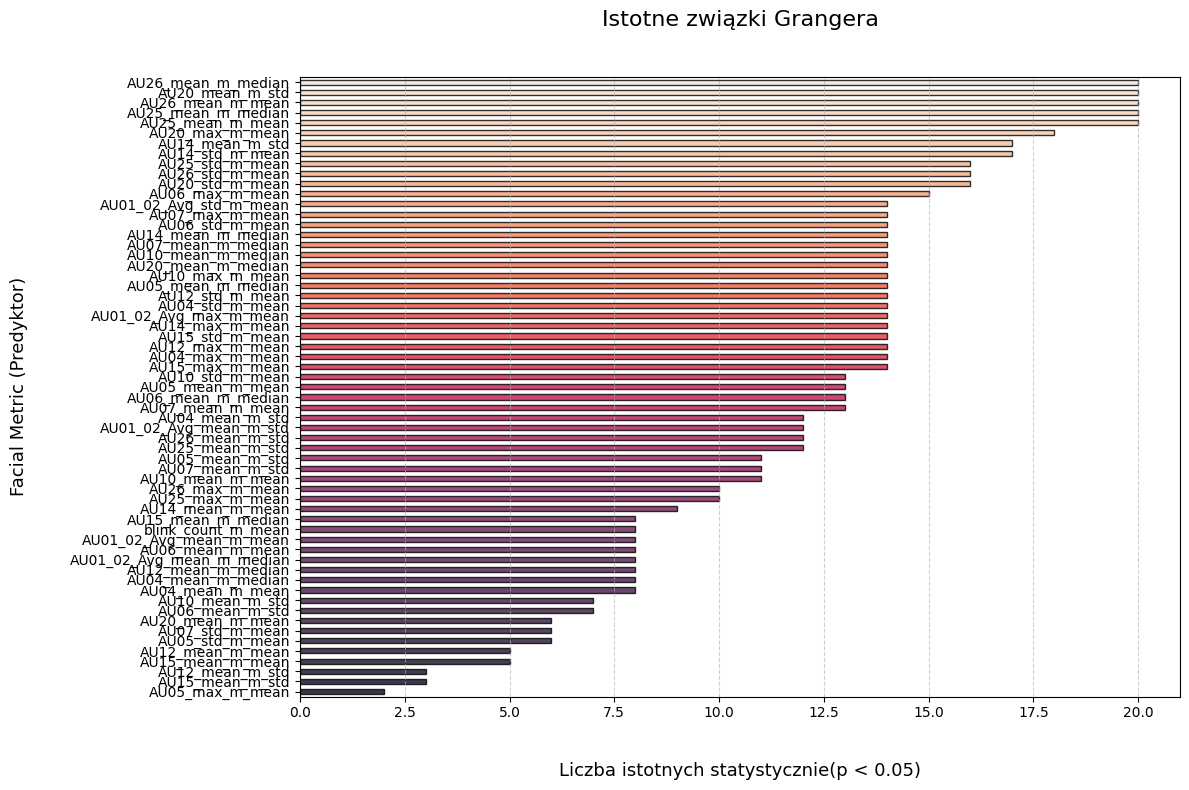

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_results = pd.read_csv('granger_causality_results.csv')

plt.figure(figsize=(12, 8))

predictor_counts = df_results['Predictor'].value_counts().sort_values(ascending=True)
colors = sns.color_palette("rocket", len(predictor_counts))

predictor_counts.plot(kind='barh', color=colors, edgecolor='black', alpha=0.8)

plt.title('Istotne związki Grangera\n', fontsize=16, pad=20)

plt.xlabel('\nLiczba istotnych statystycznie(p < 0.05)', fontsize=13, labelpad=15)
plt.ylabel('Facial Metric (Predyktor)\n', fontsize=13, labelpad=15)

plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.subplots_adjust(left=0.3)

plt.tight_layout()
plt.savefig('predictive_ranking_improved.png', dpi=300)
plt.show()

###Pearson - analiza lagów

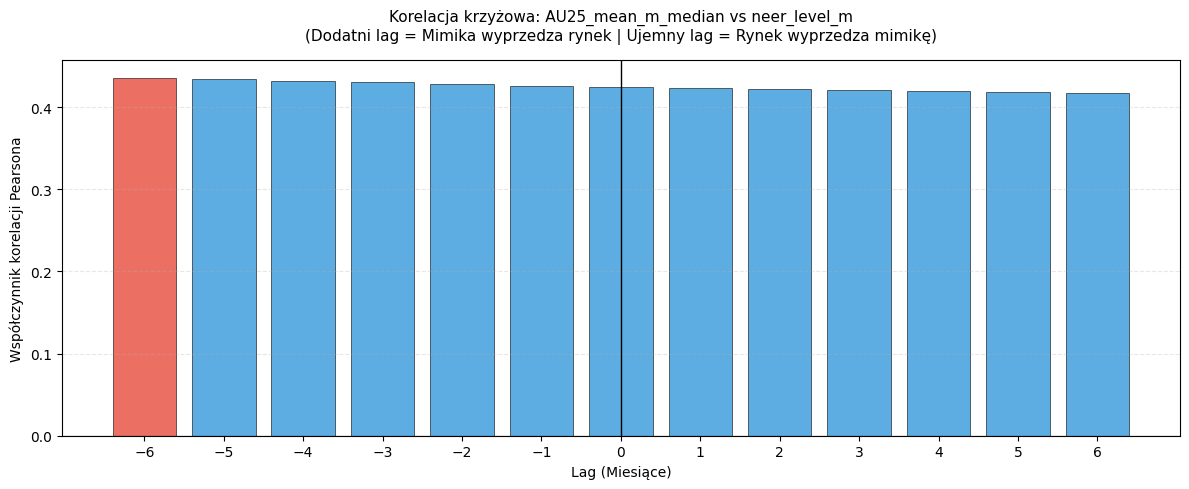

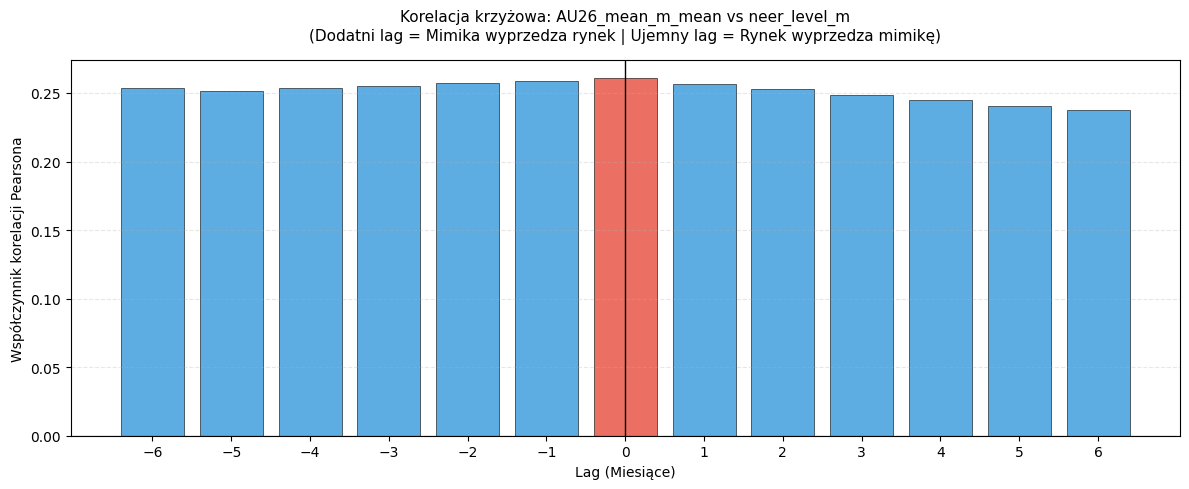

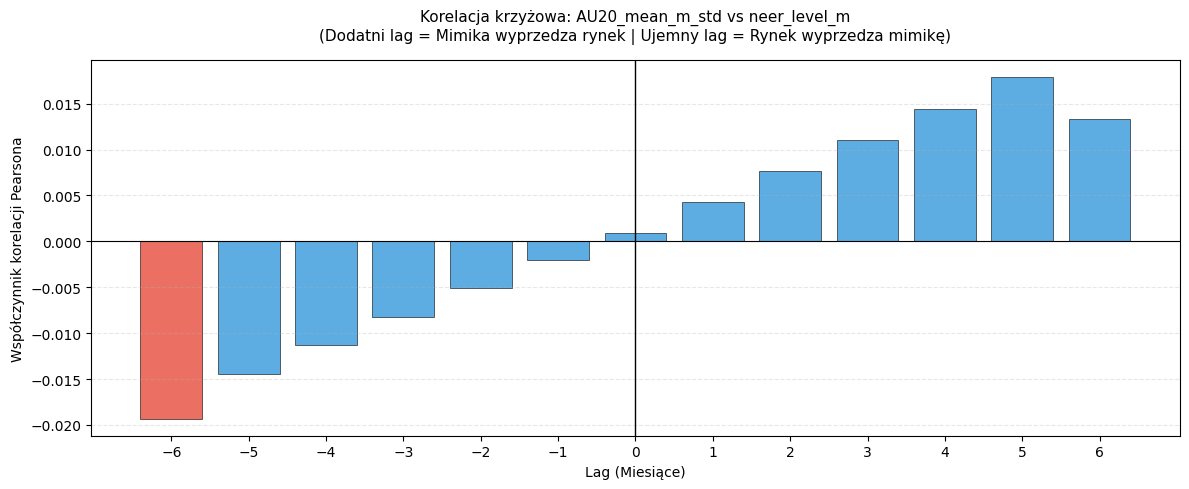

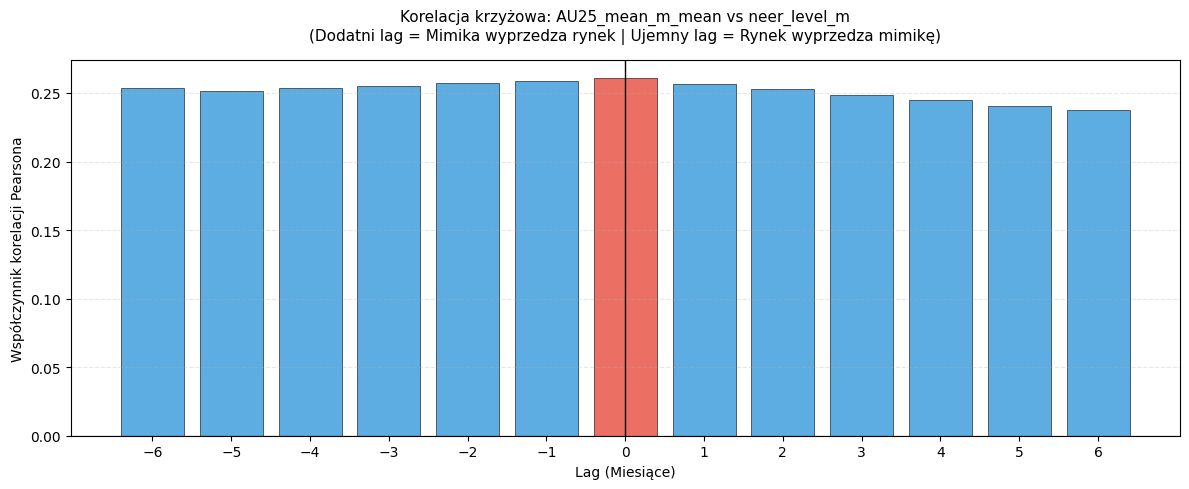

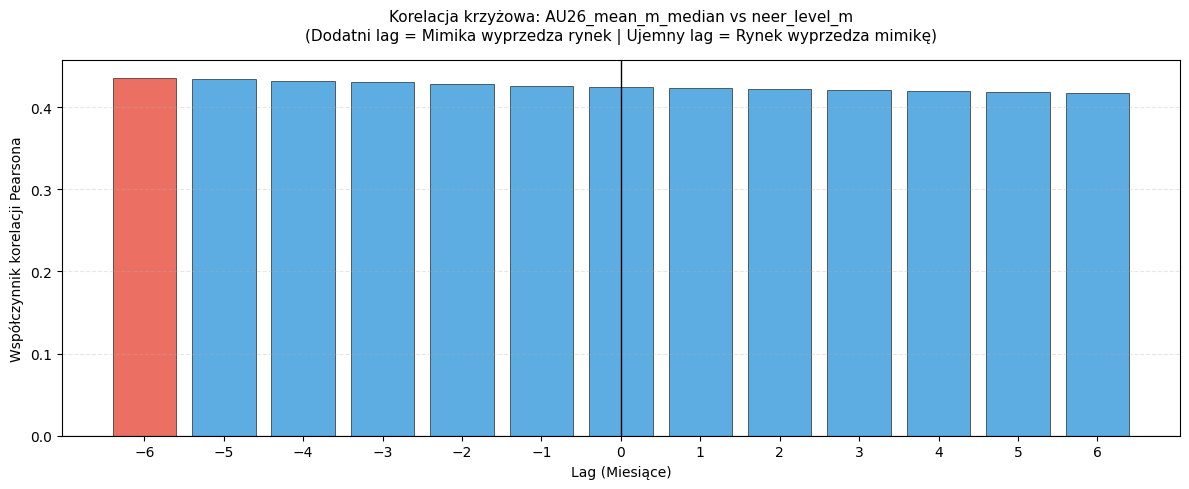

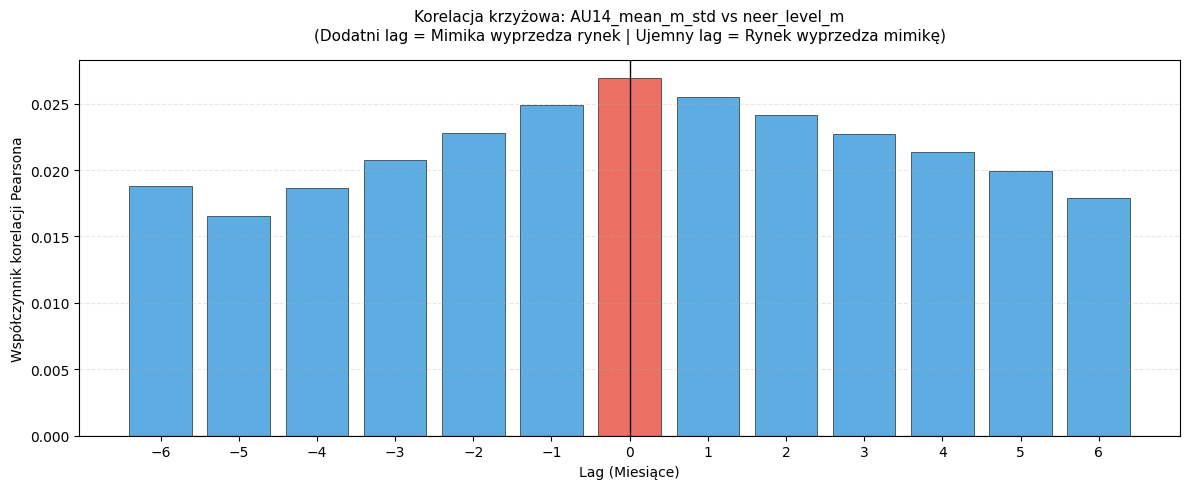

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_cross_correlation(df, predictor, target, lags=6):
    data = df[['month_str', predictor, target]].dropna().copy()
    data = data.sort_values('month_str')

    corrs = []
    lag_range = range(-lags, lags + 1)

    for lag in lag_range:
        #lag > 0: Mimika z przeszłości vs Rynek teraz (Mimika wyprzedza)
        #lag < 0: Rynek z przeszłości vs Mimika teraz (Rynek wyprzedza)
        correlation = data[predictor].shift(lag).corr(data[target])
        corrs.append(correlation)

    plt.figure(figsize=(12, 5))

    abs_corrs = np.abs(corrs)
    colors = ['#e74c3c' if a == max(abs_corrs) else '#3498db' for a in abs_corrs]

    plt.bar(lag_range, corrs, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

    plt.axvline(0, color='black', linestyle='-', lw=1)
    plt.axhline(0, color='black', lw=0.8)

    plt.title(f'Korelacja krzyżowa: {predictor} vs {target}\n'
              f'(Dodatni lag = Mimika wyprzedza rynek | Ujemny lag = Rynek wyprzedza mimikę)',
              fontsize=11, pad=15)
    plt.xlabel('Lag (Miesiące)', fontsize=10)
    plt.ylabel('Współczynnik korelacji Pearsona', fontsize=10)

    plt.xticks(lag_range)
    plt.grid(axis='y', alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()

#TOP 6 PREDYKTORÓW
plot_cross_correlation(sample_data, 'AU25_mean_m_median', 'neer_level_m')
plot_cross_correlation(sample_data, 'AU26_mean_m_mean', 'neer_level_m')
plot_cross_correlation(sample_data, 'AU20_mean_m_std', 'neer_level_m')
plot_cross_correlation(sample_data, 'AU25_mean_m_mean', 'neer_level_m')
plot_cross_correlation(sample_data, 'AU26_mean_m_median', 'neer_level_m')
plot_cross_correlation(sample_data, 'AU14_mean_m_std', 'neer_level_m')

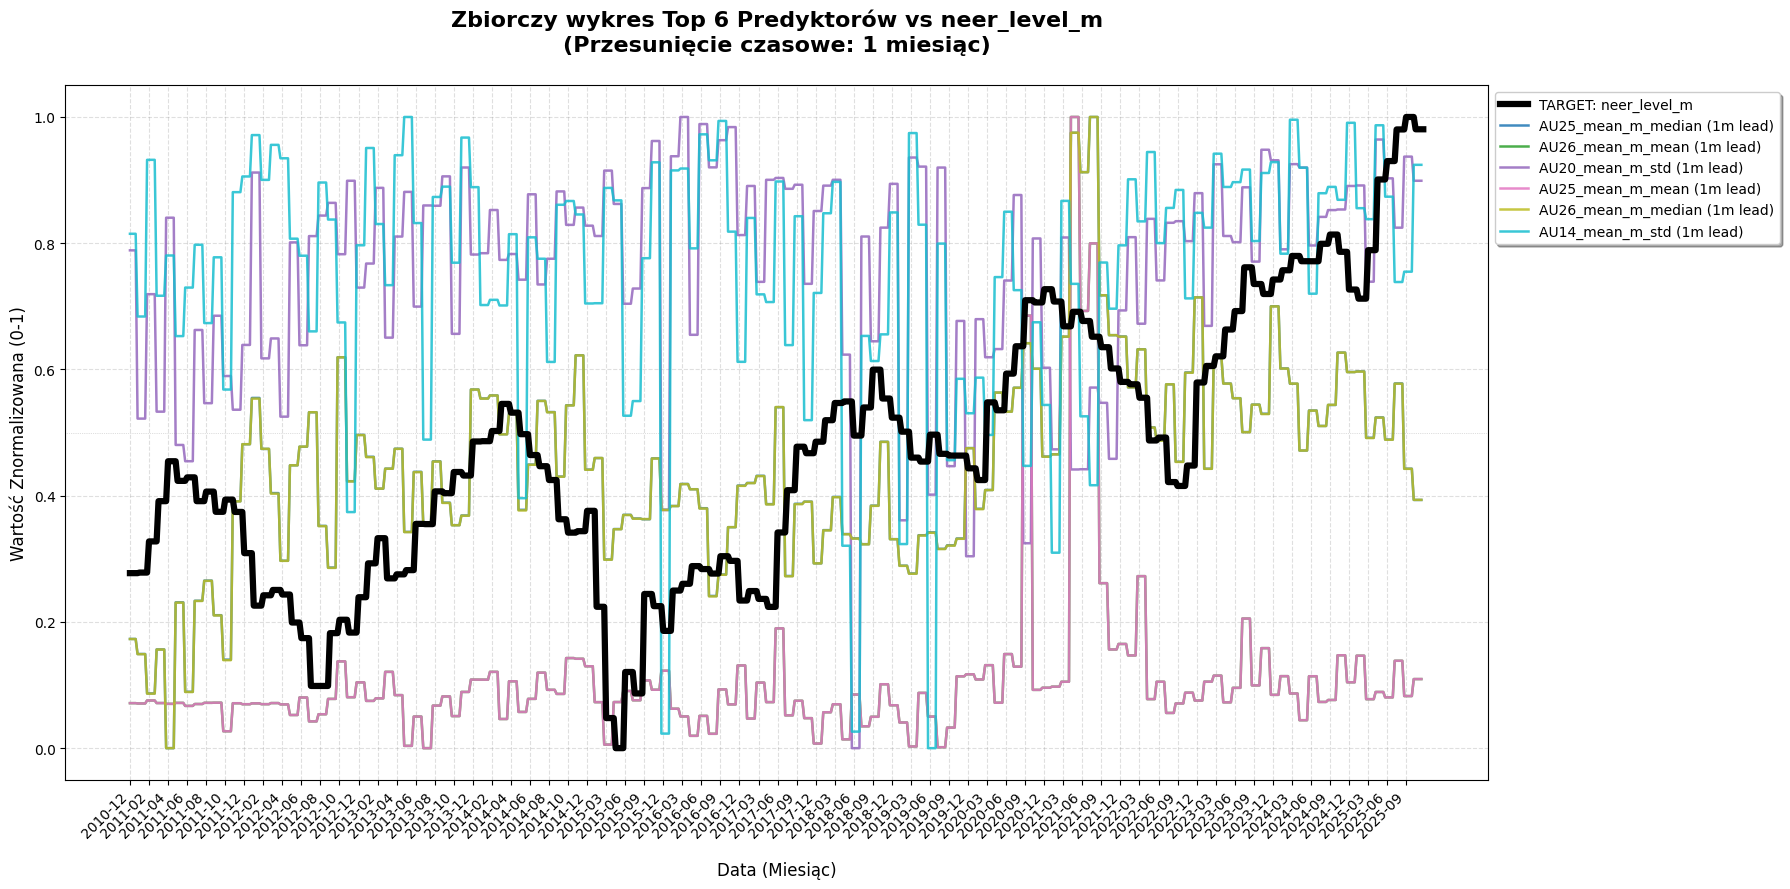

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def plot_all_combined(df, predictors, target, lead=1):
    available_predictors = [p for p in predictors if p in df.columns]
    cols_to_use = ['month_str', target] + available_predictors

    plot_data = df[cols_to_use].dropna().copy()
    plot_data = plot_data.sort_values('month_str').reset_index(drop=True)

    if plot_data.empty:
        print("Brak danych do wyświetlenia po usunięciu wartości NaN.")
        return

    scaler = MinMaxScaler()
    numeric_cols = [target] + available_predictors
    plot_data[numeric_cols] = scaler.fit_transform(plot_data[numeric_cols])

    fig, ax = plt.subplots(figsize=(18, 9))

    ax.plot(plot_data.index, plot_data[target],
            label=f'TARGET: {target}', color='black', lw=4.5, zorder=10)

    colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, len(available_predictors)))

    for i, pred in enumerate(available_predictors):
        ax.plot(plot_data.index, plot_data[pred].shift(-lead),
                label=f'{pred} ({lead}m lead)', color=colors[i], lw=1.8, alpha=0.85)

    tick_spacing = 10
    indices = np.arange(0, len(plot_data), tick_spacing)
    labels = [plot_data['month_str'].iloc[i] for i in indices]

    ax.xaxis.set_major_locator(ticker.FixedLocator(indices))
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)

    plt.title(f'Zbiorczy wykres Top 6 Predyktorów vs {target}\n(Przesunięcie czasowe: {lead} miesiąc)',
              fontsize=16, pad=25, fontweight='bold')
    plt.xlabel("Data (Miesiąc)", fontsize=12, labelpad=15)
    plt.ylabel("Wartość Znormalizowana (0-1)", fontsize=12)

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=True, shadow=True, fontsize=10)

    plt.grid(alpha=0.25, linestyle='--', color='gray')

    plt.axhline(0.5, color='gray', lw=0.5, alpha=0.5, ls=':')

    plt.tight_layout()
    plt.show()

top_6_predictors = [
    'AU25_mean_m_median', #Lips part (Median - Stabilność)
    'AU26_mean_m_mean',   #Jaw drop (Mean - Intensywność)
    'AU20_mean_m_std',    #Lip stretcher (Std - Mikrowycieki/Stres)
    'AU25_mean_m_mean',   #Lips part (Mean)
    'AU26_mean_m_median', #Jaw drop (Median)
    'AU14_mean_m_std'     #Dimpler (Std - Subtelne napięcie)
]

plot_all_combined(sample_data, top_6_predictors, 'neer_level_m', lead=1)

###Analiza znaczenia mikrogestów

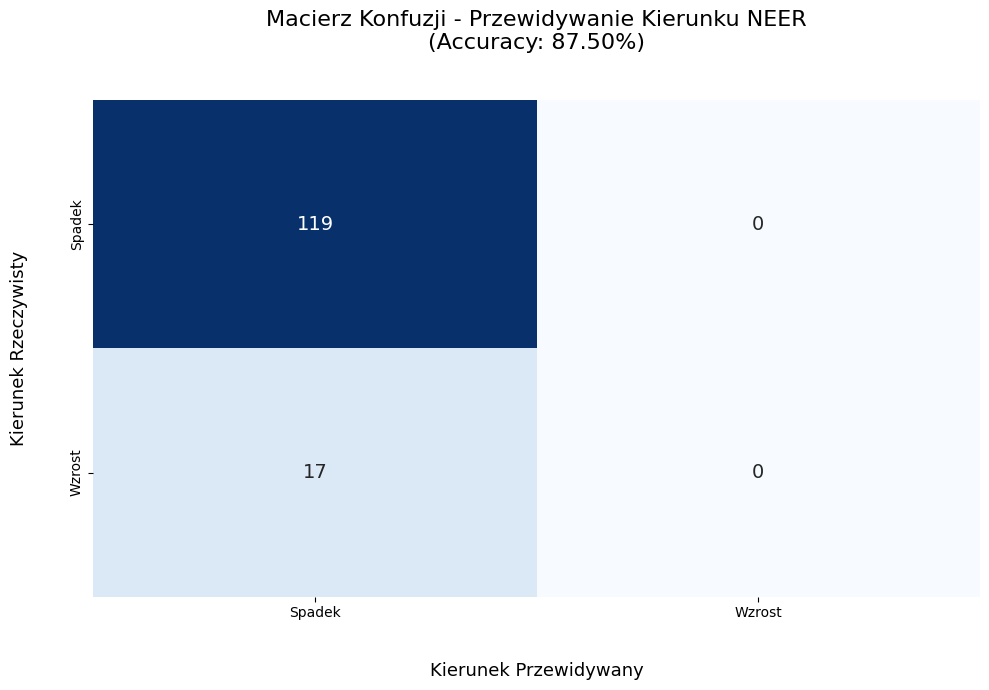

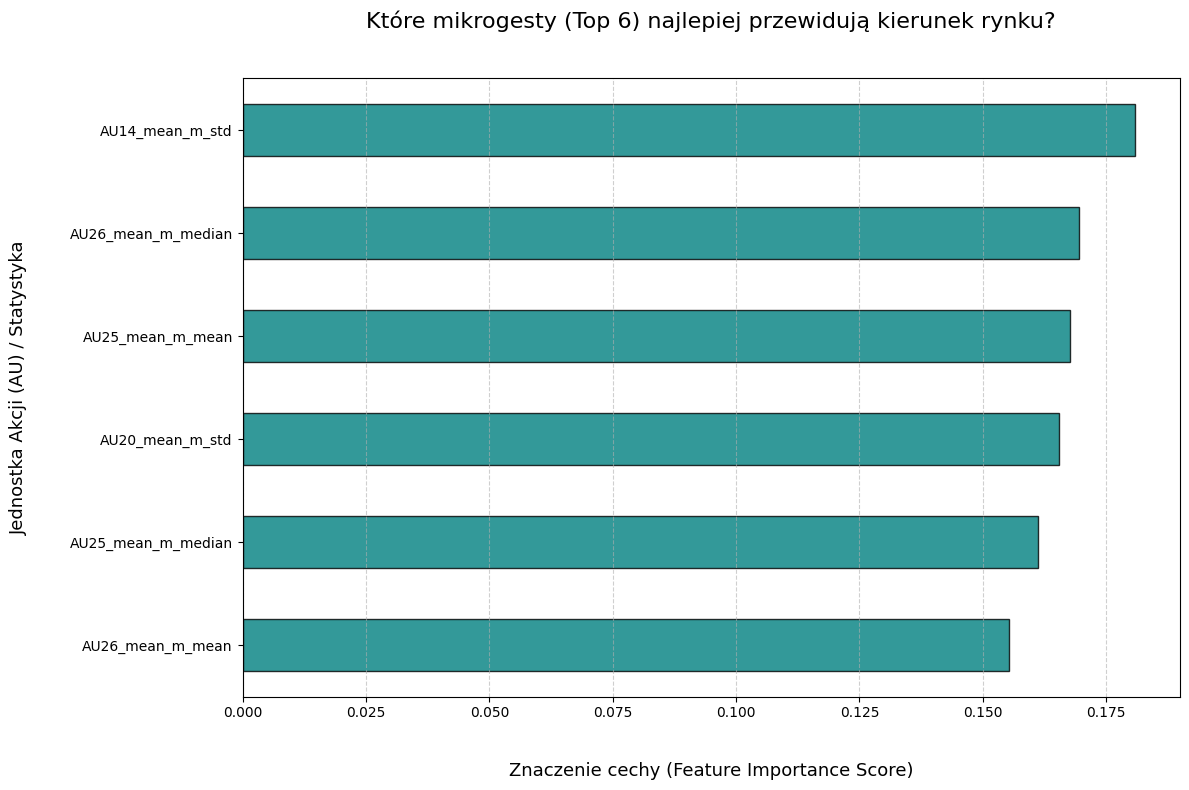

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

ml_data = sample_data.copy().sort_values('month_str')

ml_data['Target_Direction'] = (ml_data['neer_level_m'].shift(-1) > ml_data['neer_level_m']).astype(int)

features = [
    'AU25_mean_m_median',
    'AU26_mean_m_mean',
    'AU20_mean_m_std',
    'AU25_mean_m_mean',
    'AU26_mean_m_median',
    'AU14_mean_m_std'
]

X = ml_data[features].dropna()
y = ml_data.loc[X.index, 'Target_Direction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Spadek', 'Wzrost'],
            yticklabels=['Spadek', 'Wzrost'],
            annot_kws={"size": 14}, cbar=False)

plt.title(f'Macierz Konfuzji - Przewidywanie Kierunku NEER\n(Accuracy: {accuracy_score(y_test, y_pred):.2%})\n',
          fontsize=16, pad=20)
plt.xlabel('\nKierunek Przewidywany', fontsize=13, labelpad=15)
plt.ylabel('Kierunek Rzeczywisty\n', fontsize=13, labelpad=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))

importances = pd.Series(rf_model.feature_importances_, index=features).sort_values()

importances.plot(kind='barh', color='teal', edgecolor='black', alpha=0.8)

plt.title('Które mikrogesty (Top 6) najlepiej przewidują kierunek rynku?\n', fontsize=16, pad=20)
plt.xlabel('\nZnaczenie cechy (Feature Importance Score)', fontsize=13, labelpad=15)
plt.ylabel('Jednostka Akcji (AU) / Statystyka\n', fontsize=13, labelpad=15)

plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

##Testowanie modeli

###Analiza skuteczności na poszczególnych zmiennych



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
import os

warnings.filterwarnings('ignore')

df_facial = pd.read_csv('final_data.csv')

currency_map = {
    'EURUSD_Level': 'ecb_fx_usd_2010.csv',
    'EURGBP_Level': 'ecb_fx_gbp_2010.csv',
    'EURJPY_Level': 'ecb_fx_jpy_2010.csv',
    'EURCHF_Level': 'ecb_fx_chf_2010.csv',
    'EURCNY_Level': 'ecb_fx_cny_2010.csv'
}

def load_ecb_monthly(file_path, col_name):
    if not os.path.exists(file_path):
        print(f"  Brak pliku: {file_path}")
        return None
    d = pd.read_csv(file_path)
    d['Date'] = pd.to_datetime(d['Date'])
    d['month_str'] = d['Date'].dt.to_period('M').astype(str)
    return d.groupby('month_str')['Rate'].mean().rename(col_name)

for target, file in currency_map.items():
    external_rates = load_ecb_monthly(file, target)
    if external_rates is not None:
        if target not in df_facial.columns:
            df_facial[target] = np.nan
        df_facial[target] = df_facial[target].fillna(df_facial['month_str'].map(external_rates))

target_cols = [c for c in df_facial.columns if any(x in c for x in ['_Level', '_Vol', 'neer_', 'fx_'])]
df_facial[target_cols] = df_facial[target_cols].interpolate(method='linear').ffill().bfill()

au_features = [c for c in df_facial.columns if 'AU' in c or 'blink_rate' in c.lower()]

print(f"Baza gotowa. Liczba wierszy: {len(df_facial)}. Liczba cech AU: {len(au_features)}")
print(f"Analizowane wskaźniki (Targets): {len(target_cols)}")

def run_master_analysis(df, features, target_name):
    print(f"Analiza: {target_name}...", end=" ")

    df_ml = df[['month_str', target_name] + features].copy()
    df_ml['TARGET_FUTURE'] = df_ml[target_name].shift(-1)
    data_clean = df_ml.dropna()

    if len(data_clean) < 15:
        print("Pominięto (zbyt mało danych).")
        return None

    X = data_clean[features]
    y = data_clean['TARGET_FUTURE']

    scaler_x, scaler_y = MinMaxScaler(), MinMaxScaler()
    X_s = scaler_x.fit_transform(X)
    y_s = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

    split = int(len(X_s) * 0.8)
    X_train, X_test = X_s[:split], X_s[split:]
    y_train, y_test = y_s[:split], y_s[split:]
    y_test_orig = y.values[split:]

    models_config = {
        'Ridge': (Ridge(), {'alpha': [0.01, 0.1, 1.0, 10.0]}),
        'SVR': (SVR(), {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1]}),
        'Neural Net': (MLPRegressor(max_iter=1000, random_state=42),
                       {'hidden_layer_sizes': [(64,), (128,), (64, 32)], 'alpha': [0.0001, 0.001]}),
        'Random Forest': (RandomForestRegressor(random_state=42),
                          {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None]}),
        'Gradient Boosting': (GradientBoostingRegressor(random_state=42),
                              {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1]}),
        'Linear Regression': (LinearRegression(), {})
    }

    results = []

    for name, (model, params) in models_config.items():
        try:
            if params:
                search = RandomizedSearchCV(model, params, n_iter=5, cv=3, random_state=42)
                search.fit(X_train, y_train)
                best_model = search.best_estimator_
            else:
                best_model = model.fit(X_train, y_train)

            preds_s = best_model.predict(X_test)

            preds_orig = scaler_y.inverse_transform(preds_s.reshape(-1, 1)).flatten()

            r2 = r2_score(y_test, preds_s)
            mae = mean_absolute_error(y_test_orig, preds_orig)
            rmse = np.sqrt(mean_squared_error(y_test_orig, preds_orig))

            current_val = data_clean[target_name].values[split:]
            actual_dir = np.sign(y_test_orig - current_val)
            pred_dir = np.sign(preds_orig - current_val)
            acc = np.mean(actual_dir == pred_dir) * 100

            #Obliczanie Global Score (40% R2 + 60% Accuracy)
            #Ujemne R2 traktujemy jako 0
            g_score = (max(0, r2) * 0.4) + (acc / 100 * 0.6)

            results.append({
                'Target': target_name,
                'Model': name,
                'R2': round(r2, 4),
                'MAE': round(mae, 6),
                'RMSE': round(rmse, 6),
                'Dir_Accuracy_%': round(acc, 2),
                'Global_Score': round(g_score, 4)
            })
        except:
            continue

    print("Zakończono")
    return results

all_final_results = []

for target in target_cols:
    res = run_master_analysis(df_facial, au_features, target)
    if res:
        all_final_results.extend(res)

report_df = pd.DataFrame(all_final_results)

report_sorted = report_df.sort_values(by='Global_Score', ascending=False)

print("\n" + "="*90)
print("TOP 15 KONFIGURACJI")
print("="*90)
print(report_sorted.head(15).to_string(index=False))

report_sorted.to_csv('final_comprehensive_ml_report.csv', index=False)

print("\n" + "="*90)
print("NAJLEPSZA STRATEGIA DLA KAŻDEGO WSKAŹNIKA")
print("="*90)
best_per_target = report_sorted.loc[report_sorted.groupby('Target')['Global_Score'].idxmax()]
print(best_per_target[['Target', 'Model', 'Global_Score', 'Dir_Accuracy_%', 'R2']].sort_values('Global_Score', ascending=False).to_string(index=False))

Baza gotowa. Liczba wierszy: 680. Liczba cech AU: 108
Analizowane wskaźniki (Targets): 20
Analiza: EURCHF_Level... Zakończono
Analiza: EURCHF_Vol... Zakończono
Analiza: EURCNY_Level... Zakończono
Analiza: EURCNY_Vol... Zakończono
Analiza: EURGBP_Level... Zakończono
Analiza: EURGBP_Vol... Zakończono
Analiza: EURJPY_Level... Zakończono
Analiza: EURJPY_Vol... Zakończono
Analiza: EURUSD_Level... Zakończono
Analiza: EURUSD_Vol... Zakończono
Analiza: fx_min_vol_m... Zakończono
Analiza: fx_pair_correlation_m... Zakończono
Analiza: fx_peak_vol_m... Zakończono
Analiza: fx_volatility_m... Zakończono
Analiza: neer_change_m... Zakończono
Analiza: neer_level_m... Zakończono
Analiza: neer_max_m... Zakończono
Analiza: neer_min_m... Zakończono
Analiza: neer_momentum_m... Zakończono
Analiza: neer_volatility_m... Zakończono

TOP 15 KONFIGURACJI
               Target         Model     R2      MAE     RMSE  Dir_Accuracy_%  Global_Score
         EURCHF_Level Random Forest 0.9995 0.001401 0.002348          

START ANALIZY DLA 20 TARGETÓW

Istotna predykcja: EURCNY_Level przez Random Forest (R2: 0.18)


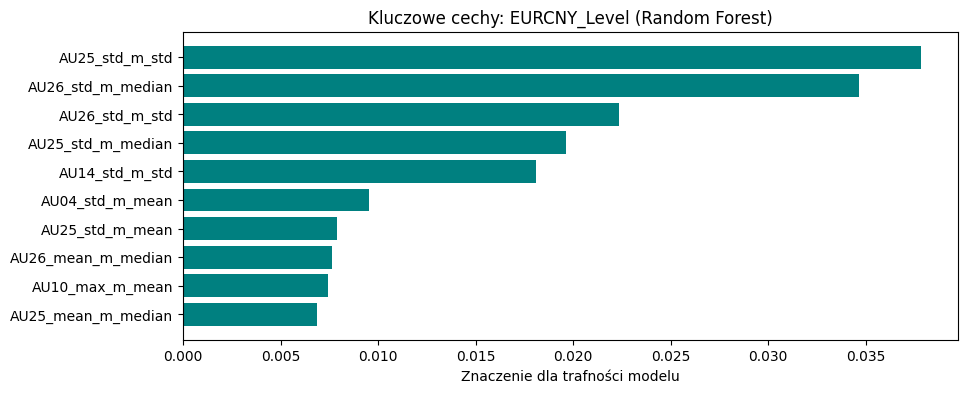


TOP 10 NAJLEPSZYCH PREDYKCJI 
          Target              Model  R2_Score  Better_Than_Dummy
15  EURCNY_Level      Random Forest  0.182663               True
22    EURCNY_Vol  Gradient Boosting  0.001262               True
58    EURUSD_Vol  Gradient Boosting -0.000421               True
57    EURUSD_Vol      Random Forest -0.006315               True
54    EURUSD_Vol              Ridge -0.013871              False
18    EURCNY_Vol              Ridge -0.024362              False
21    EURCNY_Vol      Random Forest -0.024673              False
33    EURGBP_Vol      Random Forest -0.028751              False
46    EURJPY_Vol  Gradient Boosting -0.029618              False
56    EURUSD_Vol         Neural Net -0.032762              False


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings('ignore')

models_to_analyze = {
    'Ridge': Ridge(alpha=1.0),
    'SVR': SVR(C=1.0),
    'Neural Net': MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Linear Regression': LinearRegression()
}

comprehensive_report = []

print(f"START ANALIZY DLA {len(target_cols)} TARGETÓW")

for target in target_cols:
    df_ml = df_facial[['month_str', target] + au_features].copy()
    df_ml['TARGET_FUTURE'] = df_ml[target].shift(-1)
    data_clean = df_ml.dropna().sort_values('month_str')

    if len(data_clean) < 10:
        continue

    X = data_clean[au_features]
    y = data_clean['TARGET_FUTURE']

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_x.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

    split = int(len(X_scaled) * 0.8)
    X_train, X_test = X_scaled[:split], X_scaled[split:]
    y_train, y_test = y_scaled[:split], y_scaled[split:]

    dummy = DummyRegressor(strategy="mean").fit(X_train, y_train)
    dummy_preds = dummy.predict(X_test)
    r2_dummy = r2_score(y_test, dummy_preds)

    for name, model in models_to_analyze.items():
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2_model = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)

            comprehensive_report.append({
                'Target': target,
                'Model': name,
                'R2_Score': r2_model,
                'MAE_Scaled': mae,
                'Better_Than_Dummy': r2_model > r2_dummy
            })

            if r2_model > 0.05:
                print(f"\nIstotna predykcja: {target} przez {name} (R2: {r2_model:.2f})")

                result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42)
                perm_sorted_idx = result.importances_mean.argsort()[-10:]

                plt.figure(figsize=(10, 4))
                plt.barh(np.array(au_features)[perm_sorted_idx], result.importances_mean[perm_sorted_idx], color='teal')
                plt.title(f'Kluczowe cechy: {target} ({name})')
                plt.xlabel("Znaczenie dla trafności modelu")
                plt.show()

        except Exception as e:
            continue

final_df = pd.DataFrame(comprehensive_report)
summary_table = final_df.sort_values(by=['R2_Score'], ascending=False)

print("\n" + "="*40)
print("TOP 10 NAJLEPSZYCH PREDYKCJI ")
print("="*40)
print(summary_table.head(10)[['Target', 'Model', 'R2_Score', 'Better_Than_Dummy']])

summary_table.to_csv('full_market_facial_analysis_report.csv', index=False)

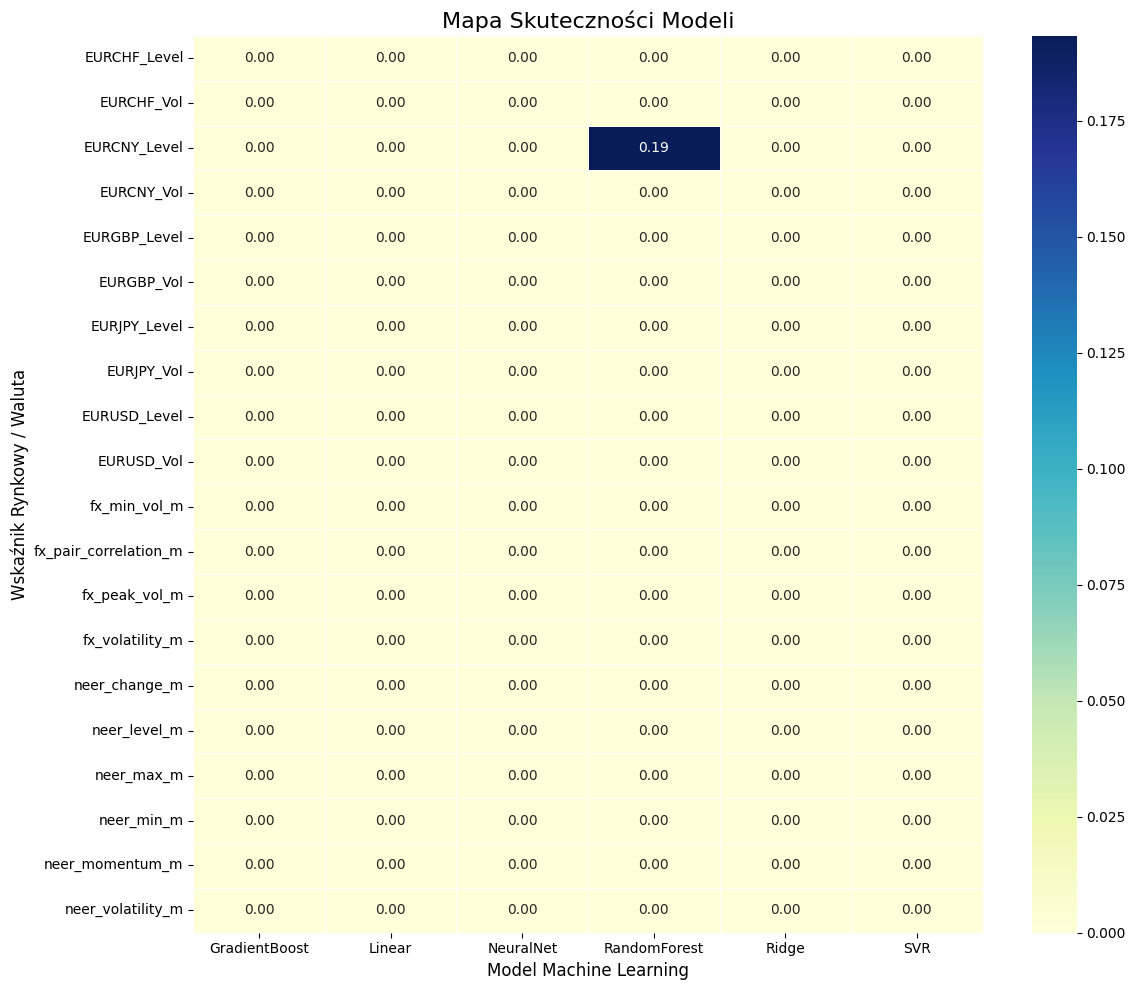

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

models_to_analyze = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'SVR': SVR(C=1.0),
    'NeuralNet': MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoost': GradientBoostingRegressor(random_state=42)
}

heatmap_results = []

for target in target_cols:
    df_ml = df_facial[['month_str', target] + au_features].copy()
    df_ml['TARGET_FUTURE'] = df_ml[target].shift(-1)
    data_clean = df_ml.dropna().sort_values('month_str')

    if len(data_clean) < 10: continue

    X = data_clean[au_features]
    y = data_clean['TARGET_FUTURE']

    scaler_x = MinMaxScaler()
    X_scaled = scaler_x.fit_transform(X)

    split = int(len(X_scaled) * 0.8)
    X_train, X_test = X_scaled[:split], X_scaled[split:]
    y_train, y_test = y[:split], y[split:]

    for name, model in models_to_analyze.items():
        try:
            model.fit(X_train, y_train)
            r2 = r2_score(y_test, model.predict(X_test))
            heatmap_results.append({'Target': target, 'Model': name, 'R2': max(0, r2)})
        except:
            continue

plot_df = pd.DataFrame(heatmap_results)
pivot_df = plot_df.pivot(index="Target", columns="Model", values="R2")

plt.figure(figsize=(12, 10))
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)
plt.title('Mapa Skuteczności Modeli', fontsize=16)
plt.xlabel('Model Machine Learning', fontsize=12)
plt.ylabel('Wskaźnik Rynkowy / Waluta', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np

verification_results = []

tscv = TimeSeriesSplit(n_splits=5)
model_to_verify = RandomForestRegressor(n_estimators=100, random_state=42)


for target in target_cols:
    try:
        df_target = df_facial[['month_str', target] + au_features].copy()
        df_target['TARGET_FUTURE'] = df_target[target].shift(-1)
        data_clean = df_target.dropna().sort_values('month_str')

        if len(data_clean) < 15: continue

        X = data_clean[au_features].values
        y = data_clean['TARGET_FUTURE'].values
        current_vals = data_clean[target].values

        most_frequent_dir = pd.Series(np.sign(y - current_vals)).mode()[0]
        naive_acc = np.mean(np.sign(y - current_vals) == most_frequent_dir) * 100

        step_scores = []
        for train_index, test_index in tscv.split(X):
            model_to_verify.fit(X[train_index], y[train_index])
            preds = model_to_verify.predict(X[test_index])

            actual_dir = np.sign(y[test_index] - current_vals[test_index])
            pred_dir = np.sign(preds - current_vals[test_index])
            acc = np.mean(actual_dir == pred_dir) * 100
            step_scores.append(acc)

        mean_cv_acc = np.mean(step_scores)

        verification_results.append({
            'Target': target,
            'CV_Mean_Accuracy_%': round(mean_cv_acc, 2),
            'Naive_Accuracy_%': round(naive_acc, 2),
            'Edge_Over_Market': round(mean_cv_acc - naive_acc, 2),
            'Last_Step_Acc_%': round(step_scores[-1], 2)
        })
    except Exception as e:
        continue

verify_df = pd.DataFrame(verification_results).sort_values(by='Edge_Over_Market', ascending=False)

print("\n" + "="*70)
print("RAPORT WIARYGODNOŚCI MODELI (CV vs NAIVE)")
print("="*70)
print(verify_df.to_string(index=False))

verify_df.to_csv('model_stability_verification.csv', index=False)


RAPORT WIARYGODNOŚCI MODELI (CV vs NAIVE)
               Target  CV_Mean_Accuracy_%  Naive_Accuracy_%  Edge_Over_Market  Last_Step_Acc_%
      fx_volatility_m               73.10             50.66             22.43            69.03
        fx_peak_vol_m               73.10             51.40             21.70            73.45
fx_pair_correlation_m               72.21             51.40             20.81            73.45
      neer_momentum_m               68.85             50.07             18.78            69.03
        neer_change_m               69.20             51.55             17.66            60.18
           neer_min_m               67.26             50.07             17.18            69.03
         EURCNY_Level               67.08             50.07             17.01            82.30
         EURCHF_Level               70.27             54.49             15.77            91.15
         EURJPY_Level               66.90             51.40             15.50            82.30
    nee

##Analiza całościowa modeli



In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings('ignore')

#Uwzględniono wszystkie unikalne jednostki AU i parametry wzroku z p-value < 0.05
significant_predictors = [
    'AU01_02_Avg_max_m_mean', 'AU01_02_Avg_mean_m_mean', 'AU01_02_Avg_mean_m_median',
    'AU01_02_Avg_mean_m_std', 'AU01_02_Avg_std_m_mean', 'AU04_max_m_mean',
    'AU04_mean_m_mean', 'AU04_mean_m_median', 'AU04_mean_m_std', 'AU04_std_m_mean',
    'AU05_max_m_mean', 'AU05_mean_m_mean', 'AU05_mean_m_median', 'AU05_mean_m_std',
    'AU05_std_m_mean', 'AU06_max_m_mean', 'AU06_mean_m_mean', 'AU06_mean_m_median',
    'AU06_mean_m_std', 'AU06_std_m_mean', 'AU07_max_m_mean', 'AU07_mean_m_mean',
    'AU07_mean_m_median', 'AU07_mean_m_std', 'AU07_std_m_mean', 'AU10_max_m_mean',
    'AU10_mean_m_mean', 'AU10_mean_m_median', 'AU10_mean_m_std', 'AU10_std_m_mean',
    'AU12_max_m_mean', 'AU12_mean_m_mean', 'AU12_mean_m_median', 'AU12_mean_m_std',
    'AU12_std_m_mean', 'AU14_max_m_mean', 'AU14_mean_m_mean', 'AU14_mean_m_median',
    'AU14_mean_m_std', 'AU14_std_m_mean', 'AU15_max_m_mean', 'AU15_mean_m_mean',
    'AU15_mean_m_median', 'AU15_mean_m_std', 'AU15_std_m_mean', 'AU20_max_m_mean',
    'AU20_mean_m_mean', 'AU20_mean_m_median', 'AU20_mean_m_std', 'AU20_std_m_mean',
    'AU25_max_m_mean', 'AU25_mean_m_mean', 'AU25_mean_m_median', 'AU25_mean_m_std',
    'AU25_std_m_mean', 'AU26_max_m_mean', 'AU26_mean_m_mean', 'AU26_mean_m_median',
    'AU26_mean_m_std', 'AU26_std_m_mean', 'blink_count_m_mean'
]

available_features = [f for f in significant_predictors if f in df_facial.columns]

all_targets = [
    'neer_level_m', 'neer_volatility_m', 'neer_momentum_m',
    'neer_change_m', 'neer_min_m', 'neer_max_m',
    'fx_volatility_m', 'fx_peak_vol_m', 'fx_min_vol_m', 'fx_pair_correlation_m',
    'EURUSD_Level', 'EURCHF_Level', 'EURCNY_Level', 'EURGBP_Level', 'EURJPY_Level'
]

models_to_test = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=0.1),
    'SVR_Linear': SVR(kernel='linear', C=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42),
    'GradientBoost': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'NeuralNet': MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42),

}

horizons = [1, 2, 3, 4, 5, 6]

def run_comprehensive_tournament(df, targets, features, models, horizons):
    all_results = []

    df_sorted = df.sort_values(['month_str', 'Currency_Tag']).reset_index(drop=True)

    for n in horizons:
        print(f"Analiza horyzontu t+{n}...")
        for target in targets:
            df_sorted['TARGET_FUTURE'] = df_sorted.groupby('Currency_Tag')[target].shift(-n)
            data = df_sorted.dropna(subset=['TARGET_FUTURE', target])

            if len(data) < 25:
                continue

            unique_dates = sorted(data['month_str'].unique())
            split_idx = int(len(unique_dates) * 0.8)
            train_dates = unique_dates[:split_idx]

            train_mask = data['month_str'].isin(train_dates)
            test_mask = ~train_mask

            X_train = data.loc[train_mask, features]
            X_test = data.loc[test_mask, features]
            y_train = data.loc[train_mask, 'TARGET_FUTURE']
            y_test = data.loc[test_mask, 'TARGET_FUTURE']
            current_val_test = data.loc[test_mask, target].values
            # ------------------------------------------

            scaler = StandardScaler()
            X_train_s = scaler.fit_transform(X_train)
            X_test_s = scaler.transform(X_test)

            for mod_name, model in models.items():
                try:
                    model.fit(X_train_s, y_train)
                    preds = model.predict(X_test_s)

                    r2 = r2_score(y_test, preds)
                    actual_dir = np.sign(y_test.values - current_val_test)
                    pred_dir = np.sign(preds - current_val_test)
                    acc = np.mean(actual_dir == pred_dir) * 100

                    score = (max(0, r2) * 0.4) + (acc / 100 * 0.6)

                    all_results.append({
                        'Horyzont': f't+{n}',
                        'Target': target,
                        'Model': mod_name,
                        'R2': round(r2, 4),
                        'Dir_Acc_%': round(acc, 2),
                        'Global_Score': round(score, 4)
                    })
                except:
                    continue

    return pd.DataFrame(all_results)

master_results = run_comprehensive_tournament(df_facial, all_targets, available_features, models_to_test, horizons)

print("\n" + "="*60)
print("TOP 15 NAJLEPSZYCH KONFIGURACJI")
print("="*60)
print(master_results.sort_values('Global_Score', ascending=False).head(15).to_string(index=False))

print("\n" + "="*60)
print("OPTYMALNY MODEL I HORYZONT DLA KAŻDEGO WSKAŹNIKA")
print("="*60)
best_per_target = master_results.loc[master_results.groupby('Target')['Global_Score'].idxmax()]
print(best_per_target[['Target', 'Horyzont', 'Model', 'Dir_Acc_%', 'R2', 'Global_Score']].sort_values('Global_Score', ascending=False).to_string(index=False))

master_results.to_csv('final_comprehensive_tournament_results.csv', index=False)

Analiza horyzontu t+1...
Analiza horyzontu t+2...
Analiza horyzontu t+3...
Analiza horyzontu t+4...
Analiza horyzontu t+5...
Analiza horyzontu t+6...

TOP 15 NAJLEPSZYCH KONFIGURACJI
Horyzont                Target         Model      R2  Dir_Acc_%  Global_Score
     t+4       fx_volatility_m GradientBoost  0.2310      85.19        0.6035
     t+4       fx_volatility_m  RandomForest  0.1314      88.89        0.5859
     t+4         fx_peak_vol_m  RandomForest  0.1734      85.19        0.5805
     t+4 fx_pair_correlation_m  RandomForest  0.1584      85.19        0.5745
     t+4 fx_pair_correlation_m GradientBoost  0.1549      85.19        0.5731
     t+2          fx_min_vol_m GradientBoost  0.1287      85.19        0.5626
     t+6          EURGBP_Level  RandomForest -1.7662      88.46        0.5308
     t+5          EURGBP_Level GradientBoost -1.2409      85.19        0.5111
     t+3       neer_momentum_m GradientBoost -0.1355      85.19        0.5111
     t+6         fx_peak_vol_m  Rando

Emocje nie prognozują nagłej reakcji, a raczej na tygodnie w przód.

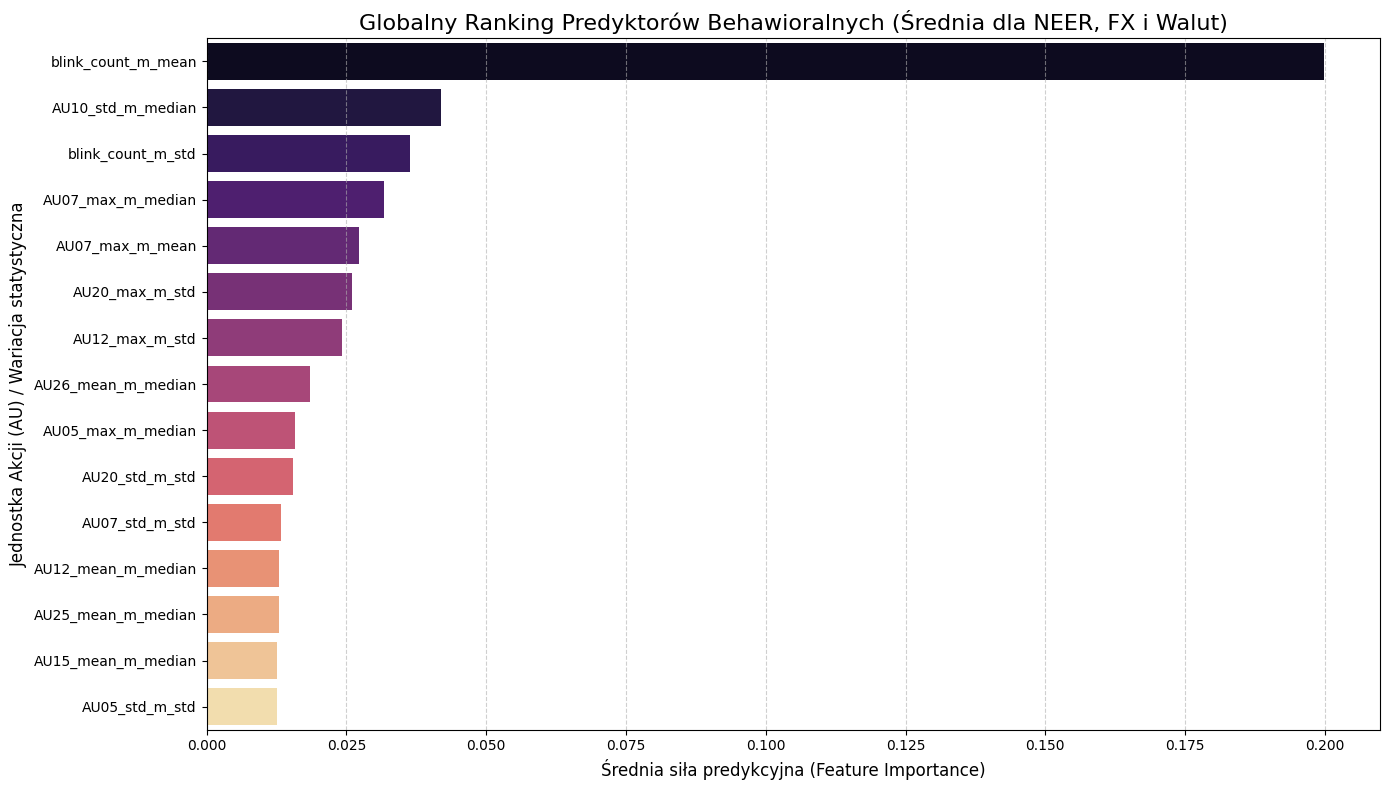

NAJSILNIEJSZE SYGNAŁY WEDŁUG KATEGORII RYNKOWEJ

Top 5 dla NEER:
  - blink_count_m_mean: 0.2379
  - AU10_std_m_median: 0.0552
  - AU07_max_m_mean: 0.0506
  - blink_count_m_std: 0.0462
  - AU20_max_m_std: 0.0438

Top 5 dla FX:
  - AU10_std_m_median: 0.0682
  - AU07_max_m_median: 0.0667
  - AU12_mean_m_median: 0.0387
  - AU15_mean_m_median: 0.0351
  - AU07_max_m_std: 0.0282

Top 5 dla Currency:
  - blink_count_m_mean: 0.3042
  - AU26_mean_m_median: 0.0452
  - blink_count_m_std: 0.0345
  - AU12_max_m_std: 0.0345
  - AU25_mean_m_median: 0.0309


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

all_targets = [
    'neer_level_m', 'neer_volatility_m', 'neer_momentum_m',
    'neer_change_m', 'neer_min_m', 'neer_max_m',
    'fx_volatility_m', 'fx_peak_vol_m', 'fx_min_vol_m', 'fx_pair_correlation_m',
    'EURUSD_Level', 'EURCHF_Level', 'EURCNY_Level', 'EURGBP_Level', 'EURJPY_Level'
]

behavioral_features = [c for c in df_facial.columns if 'AU' in c or 'blink' in c.lower()]

importance_list = []

for target in all_targets:
    df_temp = df_facial[['month_str', 'Currency_Tag', target] + behavioral_features].copy()
    df_temp = df_temp.sort_values(['Currency_Tag', 'month_str'])
    df_temp['TARGET_FUTURE'] = df_temp.groupby('Currency_Tag')[target].shift(-5)

    data_clean = df_temp.dropna(subset=['TARGET_FUTURE', target])

    if len(data_clean) < 30:
        continue

    X = data_clean[behavioral_features]
    y = data_clean['TARGET_FUTURE']

    scaler = StandardScaler()
    X_s = scaler.fit_transform(X)

    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_s, y)

    for feat, imp in zip(behavioral_features, rf.feature_importances_):
        importance_list.append({
            'Target': target,
            'Predictor': feat,
            'Importance': imp,
            'Category': 'NEER' if 'neer' in target else ('FX' if 'fx' in target else 'Currency')
        })

df_importance = pd.DataFrame(importance_list)

global_top_15 = df_importance.groupby('Predictor')['Importance'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(14, 8))
sns.barplot(x=global_top_15.values, y=global_top_15.index, palette='magma')
plt.title('Globalny Ranking Predyktorów Behawioralnych (Średnia dla NEER, FX i Walut)', fontsize=16)
plt.xlabel('Średnia siła predykcyjna (Feature Importance)', fontsize=12)
plt.ylabel('Jednostka Akcji (AU) / Wariacja statystyczna', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

category_importance = df_importance.groupby(['Category', 'Predictor'])['Importance'].mean().reset_index()
print("NAJSILNIEJSZE SYGNAŁY WEDŁUG KATEGORII RYNKOWEJ")

for cat in ['NEER', 'FX', 'Currency']:
    top_cat = category_importance[category_importance['Category'] == cat].sort_values('Importance', ascending=False).head(5)
    print(f"\nTop 5 dla {cat}:")
    for idx, row in top_cat.iterrows():
        print(f"  - {row['Predictor']}: {row['Importance']:.4f}")

Podział danych: Trening do 2022-06, Test od następnego miesiąca.
PORÓWNANIE 6 MODELI (Horyzont t+6)

Zakończono: EURUSD_Level
Zakończono: EURGBP_Level
Zakończono: EURJPY_Level
Zakończono: EURCHF_Level
Zakończono: EURCNY_Level


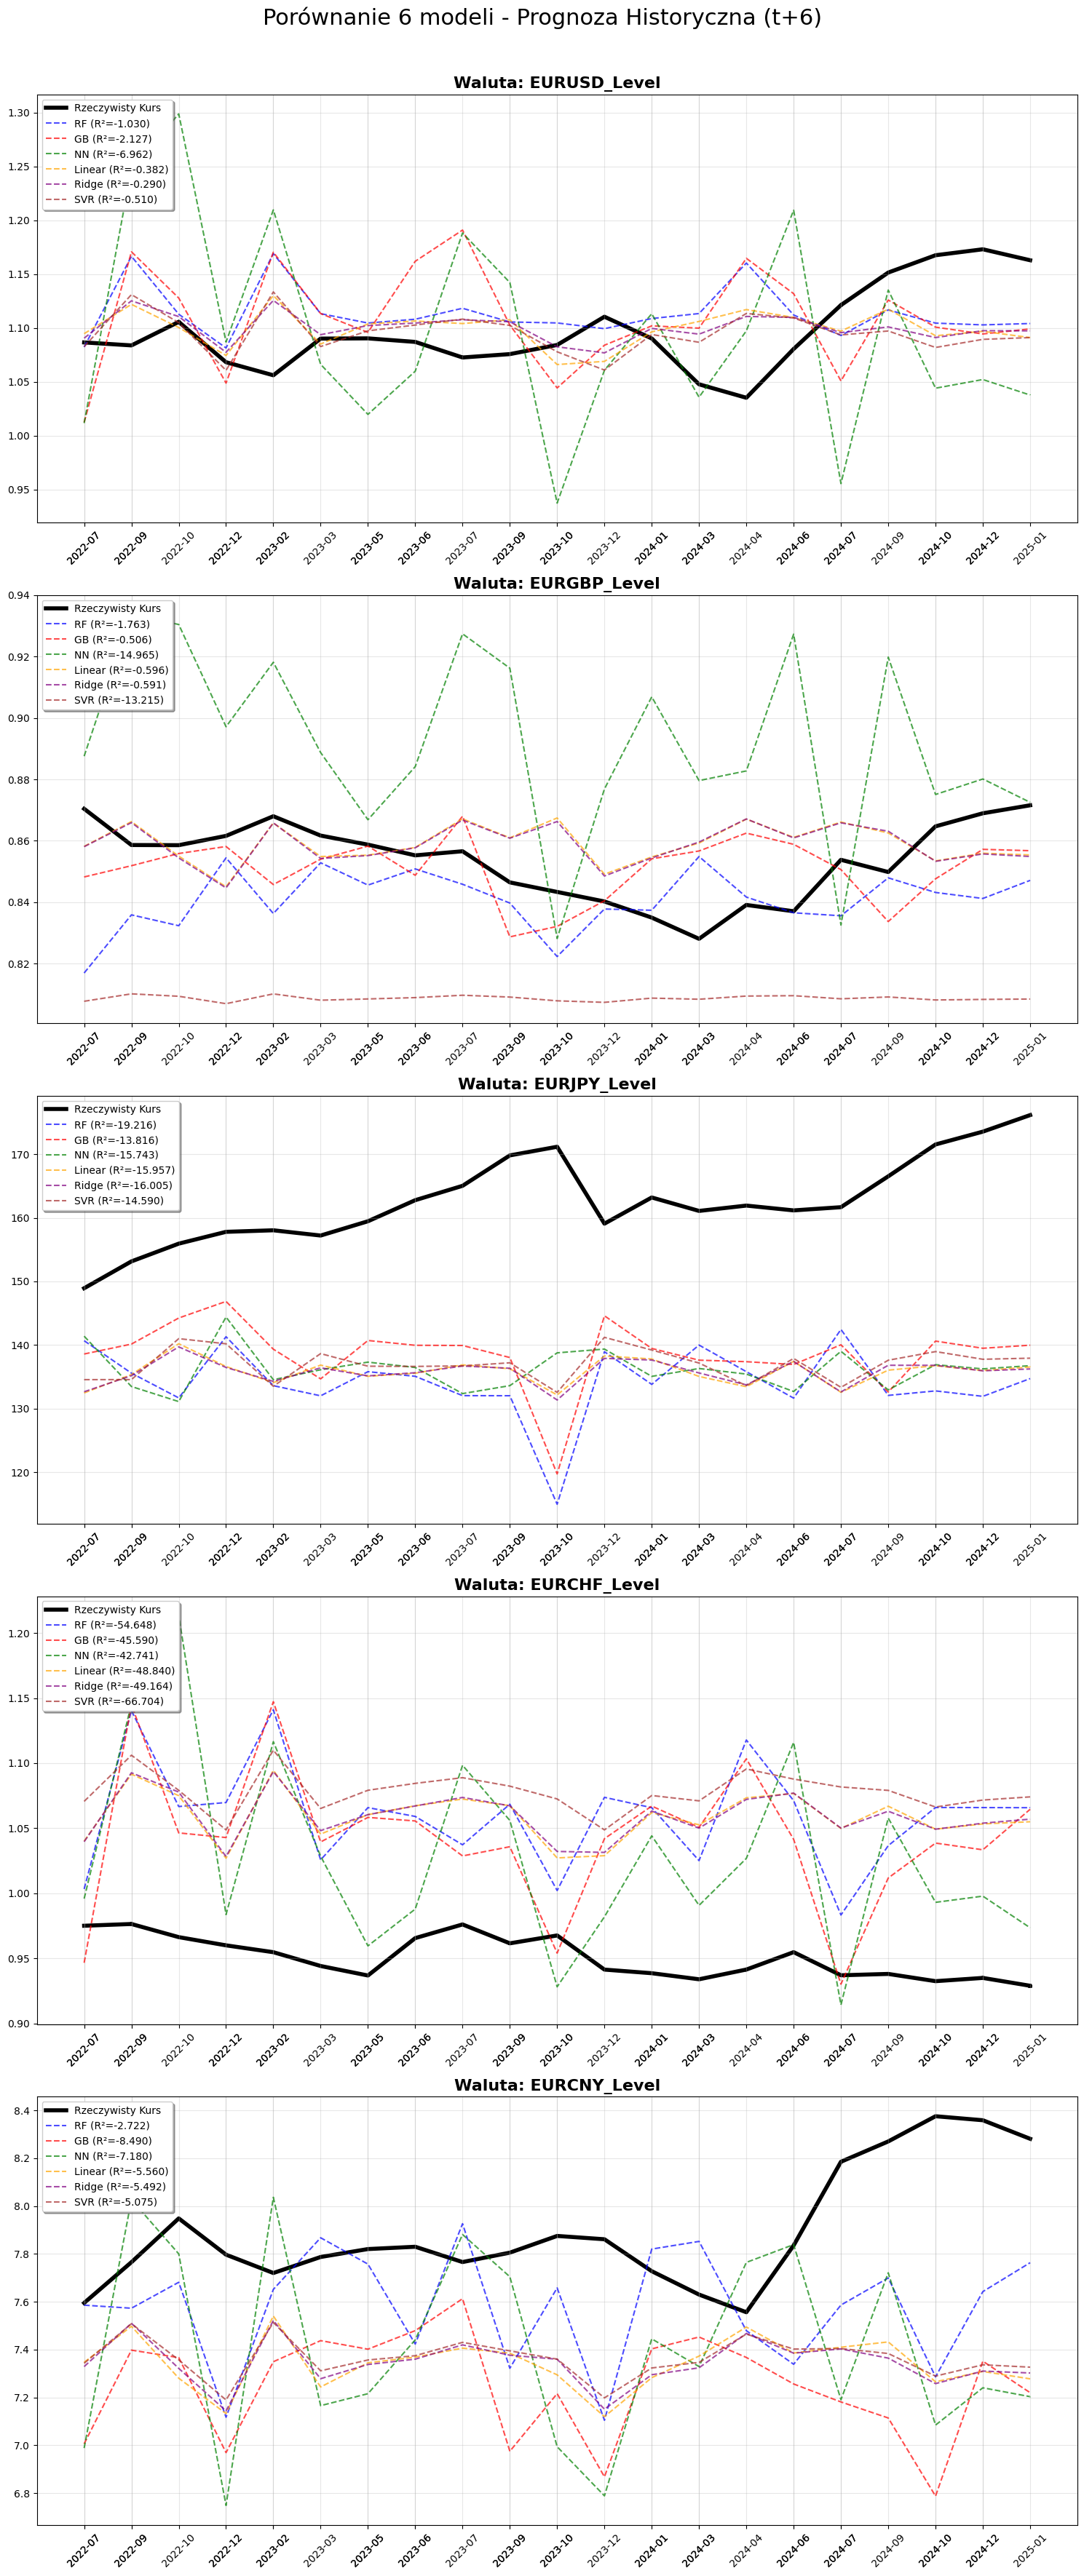


ŚREDNIA SKUTECZNOŚĆ (R2) DLA WSZYSTKICH WALUT:
RF         : -15.8757
GB         : -14.1058
NN         : -17.5183
Linear     : -14.2671
Ridge      : -14.3086
SVR        : -20.0188


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

currencies = ['EURUSD_Level', 'EURGBP_Level', 'EURJPY_Level', 'EURCHF_Level', 'EURCNY_Level']
golden_predictors = ['AU26_mean_m_median', 'AU12_max_m_std', 'AU25_mean_m_median', 'blink_count_m_mean', 'blink_count_m_std']
horyzont = 6 #Sweet Spot dla walut

history_forecasts = {cur: {} for cur in currencies}

all_dates = sorted(df_facial['month_str'].unique())
split_idx = int(len(all_dates) * 0.8)
cutoff_date = all_dates[split_idx]

print(f"Podział danych: Trening do {cutoff_date}, Test od następnego miesiąca.")
print(f"PORÓWNANIE 6 MODELI (Horyzont t+{horyzont})\n")

for cur in currencies:
    df_cur = df_facial[['month_str', 'Currency_Tag', cur] + golden_predictors].copy().sort_values('month_str')
    df_cur['TARGET_FUTURE'] = df_cur.groupby('Currency_Tag')[cur].shift(-horyzont)
    data = df_cur.dropna(subset=['TARGET_FUTURE', cur])

    train_data = data[data['month_str'] <= cutoff_date]
    test_data = data[data['month_str'] > cutoff_date]

    X_train = train_data[golden_predictors]
    y_train = train_data['TARGET_FUTURE']
    X_test = test_data[golden_predictors]
    y_test = test_data['TARGET_FUTURE']

    dates_test = test_data['month_str']

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    models = {
        'RF': RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
        'GB': GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
        'NN': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, early_stopping=True),
        'Linear': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'SVR': SVR(kernel='linear', C=1.0)
    }

    current_cur_preds = {}
    current_cur_r2 = {}

    for name, model in models.items():
        model.fit(X_train_s, y_train)
        preds = model.predict(X_test_s)
        current_cur_preds[name] = preds
        current_cur_r2[name] = r2_score(y_test, preds)

    history_forecasts[cur] = {
        'dates': dates_test,
        'actual': y_test.values,
        'preds': current_cur_preds,
        'r2_scores': current_cur_r2
    }
    print(f"Zakończono: {cur}")

fig, axes = plt.subplots(5, 1, figsize=(15, 35))
fig.suptitle(f'Porównanie 6 modeli - Prognoza Historyczna (t+{horyzont})', fontsize=22, y=1.01)

model_colors = {'RF': 'blue', 'GB': 'red', 'NN': 'green', 'Linear': 'orange', 'Ridge': 'purple', 'SVR': 'brown'}

for i, cur in enumerate(currencies):
    res = history_forecasts[cur]
    ax = axes[i]

    ax.plot(res['dates'], res['actual'], label='Rzeczywisty Kurs', color='black', lw=4, zorder=1)

    for name, preds in res['preds'].items():
        ax.plot(res['dates'], preds, label=f'{name} (R²={res["r2_scores"][name]:.3f})',
                color=model_colors[name], ls='--', alpha=0.7)

    ax.set_title(f'Waluta: {cur}', fontsize=16, fontweight='bold')
    ax.legend(loc='upper left', frameon=True, shadow=True, fontsize=10)
    ax.grid(alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticks(res['dates'][::3])

plt.tight_layout()
plt.show()

print("\n" + "="*40)
print("ŚREDNIA SKUTECZNOŚĆ (R2) DLA WSZYSTKICH WALUT:")
print("="*40)

for name in ['RF', 'GB', 'NN', 'Linear', 'Ridge', 'SVR']:
    avg_r2 = np.mean([history_forecasts[cur]['r2_scores'][name] for cur in currencies])
    print(f"{name:10s} : {avg_r2:.4f}")

##Lasso i PCA

In [ ]:
from sklearn.linear_model import LassoCV

def apply_lasso_selection(df, au_features, target_col):
    X = df[au_features]
    y = df[target_col]

    scaler = StandardScaler()
    X_s = scaler.fit_transform(X)

    lasso = LassoCV(cv=5, random_state=42).fit(X_s, y)

    important_features = np.array(au_features)[lasso.coef_ != 0]

    print(f"Lasso wybrało {len(important_features)} istotnych cech z 108 dostępnych.")
    print(f"Wybrane cechy: {important_features} ...")

    return important_features

selected_by_lasso = apply_lasso_selection(data_clean, au_features, 'TARGET_FUTURE')

Lasso wybrało 10 istotnych cech z 108 dostępnych.
Wybrane cechy: ['AU06_max_m_mean' 'AU06_max_m_median' 'AU07_max_m_mean'
 'AU07_max_m_median' 'AU10_max_m_mean' 'AU14_mean_m_median'
 'AU14_std_m_std' 'AU20_mean_m_std' 'AU25_mean_m_mean' 'AU26_mean_m_mean'] ...


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def apply_pca_and_predict(df, au_features, target_col):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[au_features])

    pca = PCA(n_components=0.90)
    X_pca = pca.fit_transform(X_scaled)

    print(f"PCA zredukowało 108 cech do {X_pca.shape[1]} składowych.")

    return X_pca, pca

X_pca, trained_pca = apply_pca_and_predict(data_clean, au_features, 'TARGET_FUTURE')

PCA zredukowało 108 cech do 13 składowych.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings('ignore')

def full_comparative_study_panel(df, target_col, au_features, n_horizon=5):
    df_ml = df.sort_values(['month_str', 'Currency_Tag']).copy()
    df_ml['TARGET_FUTURE'] = df_ml.groupby('Currency_Tag')[target_col].shift(-n_horizon)
    data = df_ml.dropna(subset=['TARGET_FUTURE', target_col])

    if len(data) < 30:
        return None

    unique_dates = sorted(data['month_str'].unique())
    split_point = int(len(unique_dates) * 0.8)
    train_dates = unique_dates[:split_point]

    train_mask = data['month_str'].isin(train_dates)
    test_mask = ~train_mask

    X_train_raw = data.loc[train_mask, au_features]
    X_test_raw = data.loc[test_mask, au_features]
    y_train = data.loc[train_mask, 'TARGET_FUTURE']
    y_test = data.loc[test_mask, 'TARGET_FUTURE']
    current_val_test = data.loc[test_mask, target_col].values

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.transform(X_test_raw)

    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    lasso = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train)
    selected_mask = lasso.coef_ != 0
    X_train_lasso = X_train_scaled[:, selected_mask]
    X_test_lasso = X_test_scaled[:, selected_mask]

    models = {
        'Linear': LinearRegression(),
        'Ridge': Ridge(alpha=0.1),
        'SVR': SVR(kernel='linear', C=1.0),
        'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42),
        'GradientBoost': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'NeuralNet': MLPRegressor(hidden_layer_sizes=(128,), alpha=0.0001, early_stopping=True, random_state=42)
    }

    target_results = []
    scenarios = {
        'Raw (108 AU)': (X_train_scaled, X_test_scaled),
        'PCA': (X_train_pca, X_test_pca),
        'Lasso Selection': (X_train_lasso, X_test_lasso)
    }

    for sc_name, (train_data, test_data) in scenarios.items():
        if train_data.shape[1] == 0: continue

        for mod_name, model in models.items():
            try:
                model.fit(train_data, y_train)
                preds = model.predict(test_data)

                r2 = r2_score(y_test, preds)
                actual_dir = np.sign(y_test.values - current_val_test)
                pred_dir = np.sign(preds - current_val_test)
                acc = np.mean(actual_dir == pred_dir) * 100

                target_results.append({
                    'Target': target_col,
                    'Scenariusz': sc_name,
                    'Model': mod_name,
                    'R2': r2,
                    'Dir_Acc': acc,
                    'Score': (max(0, r2) * 0.4) + (acc / 100 * 0.6),
                    'Features_Used': train_data.shape[1]
                })
            except:
                continue
    return target_results



list_of_targets = [
    'neer_level_m', 'neer_volatility_m', 'neer_momentum_m',
    'fx_volatility_m', 'fx_peak_vol_m', 'fx_min_vol_m',
    'EURUSD_Level', 'EURCHF_Level', 'EURCNY_Level', 'EURGBP_Level', 'EURJPY_Level'
]

all_final_results = []

print(f"Sprawdzanie {len(list_of_targets)} wskaźników...")

for t in list_of_targets:
    print(f"Analizuję: {t}...", end=" ")
    res = full_comparative_study_panel(df_facial, t, au_features, n_horizon=5)
    if res:
        all_final_results.extend(res)
        print("OK")
    else:
        print("Pominięto (brak danych)")

full_results_df = pd.DataFrame(all_final_results)

print("\n" + "="*60)
print("TOP 10 KONFIGURACJI DLA WSZYSTKICH WSKAŹNIKÓW (Horyzont t+5)")
print("="*60)
print(full_results_df.sort_values('Score', ascending=False).head(10).to_string(index=False))

print("\n" + "="*60)
print("NAJLEPSZY MODEL DLA KAŻDEGO WSKAŹNIKA Z OSOBNA")
print("="*60)
best_per_target = full_results_df.loc[full_results_df.groupby('Target')['Score'].idxmax()]
print(best_per_target[['Target', 'Scenariusz', 'Model', 'Score', 'Dir_Acc', 'R2']].sort_values('Score', ascending=False).to_string(index=False))

Sprawdzanie 11 wskaźników...
Analizuję: neer_level_m... OK
Analizuję: neer_volatility_m... OK
Analizuję: neer_momentum_m... OK
Analizuję: fx_volatility_m... OK
Analizuję: fx_peak_vol_m... OK
Analizuję: fx_min_vol_m... OK
Analizuję: EURUSD_Level... OK
Analizuję: EURCHF_Level... OK
Analizuję: EURCNY_Level... OK
Analizuję: EURGBP_Level... OK
Analizuję: EURJPY_Level... OK

TOP 10 KONFIGURACJI DLA WSZYSTKICH WSKAŹNIKÓW (Horyzont t+5)
         Target   Scenariusz         Model         R2   Dir_Acc    Score  Features_Used
   EURGBP_Level          PCA  RandomForest  -0.759394 85.185185 0.511111             18
  fx_peak_vol_m          PCA     NeuralNet  -0.132428 85.185185 0.511111             18
neer_momentum_m          PCA  RandomForest  -3.333115 81.481481 0.488889             18
   EURGBP_Level Raw (108 AU)  RandomForest  -0.898459 81.481481 0.488889            108
neer_momentum_m          PCA GradientBoost  -2.946047 77.777778 0.466667             18
   EURGBP_Level          PCA GradientBo

##Analiza kierunku rynku

In [ ]:
#przykład na EURUSD_Level
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')

def run_directional_classification_master(df, target_col, au_features, n_horizon=5):
    df_ml = df.sort_values(['month_str', 'Currency_Tag']).copy()

    df_ml['Target_Dir'] = (df_ml.groupby('Currency_Tag')[target_col].shift(-n_horizon) > df_ml[target_col]).astype(int)

    data = df_ml.dropna(subset=['Target_Dir', target_col])

    unique_dates = sorted(data['month_str'].unique())
    split_point = int(len(unique_dates) * 0.8)
    train_dates = unique_dates[:split_point]
    test_dates = unique_dates[split_point:]

    train_df = data[data['month_str'].isin(train_dates)]
    test_df = data[data['month_str'].isin(test_dates)]

    X_train_raw = train_df[au_features]
    X_test_raw = test_df[au_features]
    y_train = train_df['Target_Dir']
    y_test = test_df['Target_Dir']

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train_raw)
    X_test_s = scaler.transform(X_test_raw)


    pca = PCA(n_components=15)
    X_train_pca = pca.fit_transform(X_train_s)
    X_test_pca = pca.transform(X_test_s)

    lasso_selector = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', C=0.5))
    lasso_selector.fit(X_train_s, y_train)
    X_train_lasso = lasso_selector.transform(X_train_s)
    X_test_lasso = lasso_selector.transform(X_test_s)

    golden_features = ['AU25_mean_m_median', 'AU12_max_m_std', 'AU26_mean_m_median', 'blink_count_m_std', 'blink_count_m_mean']
    gold_indices = [au_features.index(f) for f in golden_features if f in au_features]
    X_train_gold = X_train_s[:, gold_indices]
    X_test_gold = X_test_s[:, gold_indices]

    clf_models = {
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'RidgeClassifier': RidgeClassifier(),
        'SVC': SVC(kernel='linear', C=1.0, probability=True),
        'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=7, random_state=42),
        'GradientBoost': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'NeuralNet': MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000, random_state=42)
    }

    scenarios = {
        'Raw (All AU)': (X_train_s, X_test_s),
        'PCA': (X_train_pca, X_test_pca),
        'Lasso Selection': (X_train_lasso, X_test_lasso),
        'Golden Features': (X_train_gold, X_test_gold)
    }

    results = []

    print(f"klasyfikacja dla {target_col}...")

    for sc_name, (train_data, test_data) in scenarios.items():
        for mod_name, model in clf_models.items():
            try:
                model.fit(train_data, y_train)
                y_pred = model.predict(test_data)
                acc = accuracy_score(y_test, y_pred)

                results.append({
                    'Target': target_col,
                    'Scenariusz': sc_name,
                    'Model': mod_name,
                    'Dir_Accuracy': round(acc * 100, 2),
                    'Features_Count': train_data.shape[1]
                })
            except Exception as e:
                continue

    return pd.DataFrame(results).sort_values('Dir_Accuracy', ascending=False)

final_clf_results = run_directional_classification_master(df_facial, 'EURUSD_Level', au_features, n_horizon=5)

print("\n" + "="*80)
print("RANKING KLASYFIKACJI KIERUNKOWEJ (GÓRA/DÓŁ)")
print("="*80)
print(final_clf_results.to_string(index=False))

baseline_acc = df_facial['EURUSD_Level'].diff().gt(0).mean() * 100
print(f"\nBaseline (Rzut monetą/Trend): {baseline_acc:.2f}%")

klasyfikacja dla EURUSD_Level...

RANKING KLASYFIKACJI KIERUNKOWEJ (GÓRA/DÓŁ)
      Target      Scenariusz              Model  Dir_Accuracy  Features_Count
EURUSD_Level             PCA    RidgeClassifier         53.57              15
EURUSD_Level Lasso Selection      GradientBoost         53.57              51
EURUSD_Level Golden Features          NeuralNet         50.00               3
EURUSD_Level    Raw (All AU)      GradientBoost         50.00             108
EURUSD_Level             PCA      GradientBoost         46.43              15
EURUSD_Level             PCA       RandomForest         46.43              15
EURUSD_Level             PCA LogisticRegression         46.43              15
EURUSD_Level    Raw (All AU)          NeuralNet         46.43             108
EURUSD_Level             PCA          NeuralNet         46.43              15
EURUSD_Level Lasso Selection          NeuralNet         46.43              51
EURUSD_Level Golden Features       RandomForest         42.86   

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')

def run_mega_classification_tournament(df, targets, au_features, horizons=[1, 3, 5]):
    all_results = []

    df_master = df.sort_values(['month_str', 'Currency_Tag']).copy()

    for n in horizons:
        print(f"ANALIZA HORYZONTU t+{n}")

        for target in targets:
            df_master['Target_Dir'] = (df_master.groupby('Currency_Tag')[target].shift(-n) > df_master[target]).astype(int)

            data = df_master.dropna(subset=['Target_Dir', target])
            if len(data) < 40: continue

            unique_dates = sorted(data['month_str'].unique())
            split_point = int(len(unique_dates) * 0.8)
            train_dates = unique_dates[:split_point]

            train_df = data[data['month_str'].isin(train_dates)]
            test_df = data[~data['month_str'].isin(train_dates)]

            X_train_raw = train_df[au_features]
            X_test_raw = test_df[au_features]
            y_train = train_df['Target_Dir']
            y_test = test_df['Target_Dir']

            scaler = StandardScaler()
            X_train_s = scaler.fit_transform(X_train_raw)
            X_test_s = scaler.transform(X_test_raw)

            pca = PCA(n_components=15).fit(X_train_s)

            lasso = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', C=0.2)).fit(X_train_s, y_train)
            gold_feats = ['blink_count_m_mean', 'AU10_std_m_median', 'AU07_max_m_mean', 'blink_count_m_std', 'AU20_max_m_std']

            gold_indices = [au_features.index(f) for f in gold_feats if f in au_features]

            scenarios = {
                'Raw (110 AU)': (X_train_s, X_test_s),
                'PCA (15 Comp)': (pca.transform(X_train_s), pca.transform(X_test_s)),
                'Lasso Selection': (lasso.transform(X_train_s), lasso.transform(X_test_s)),
                'Golden Features': (X_train_s[:, gold_indices], X_test_s[:, gold_indices])
            }

            models = {
                'LogReg': LogisticRegression(),
                'Ridge': RidgeClassifier(),
                'SVC': SVC(kernel='linear'),
                'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42),
                'GradientBoost': GradientBoostingClassifier(n_estimators=100, random_state=42),
                'NeuralNet': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
            }

            baseline_acc = max(y_test.mean(), 1 - y_test.mean()) * 100

            for sc_name, (X_tr, X_te) in scenarios.items():
                if X_tr.shape[1] == 0: continue

                for mod_name, model in models.items():
                    try:
                        model.fit(X_tr, y_train)
                        acc = accuracy_score(y_test, model.predict(X_te)) * 100

                        all_results.append({
                            'Horyzont': f't+{n}',
                            'Target': target,
                            'Scenariusz': sc_name,
                            'Model': mod_name,
                            'Accuracy': round(acc, 2),
                            'Baseline': round(baseline_acc, 2),
                            'Edge': round(acc - baseline_acc, 2)
                        })
                    except:
                        continue
            print(f"  Zakończono: {target}")

    return pd.DataFrame(all_results)

targets_to_test = [
    'neer_volatility_m', 'neer_momentum_m', 'neer_level_m','neer_change_m','neer_min_m', 'neer_max_m'
]

mega_results = run_mega_classification_tournament(df_facial, targets_to_test, au_features, horizons=[1,2,3,4,5,6])

print("\n" + "="*50)
print("TOP 20 NAJLEPSZYCH SYGNAŁÓW KIERUNKOWYCH (PRZEWAGA NAD RYNKIEM)")
print("="*50)
print(mega_results.sort_values('Edge', ascending=False).head(20).to_string(index=False))

mega_results.to_csv('mega_classification_results2.csv', index=False)

ANALIZA HORYZONTU t+1
  Zakończono: neer_volatility_m
  Zakończono: neer_momentum_m
  Zakończono: neer_level_m
  Zakończono: neer_change_m
  Zakończono: neer_min_m
  Zakończono: neer_max_m
ANALIZA HORYZONTU t+2
  Zakończono: neer_volatility_m
  Zakończono: neer_momentum_m
  Zakończono: neer_level_m
  Zakończono: neer_change_m
  Zakończono: neer_min_m
  Zakończono: neer_max_m
ANALIZA HORYZONTU t+3
  Zakończono: neer_volatility_m
  Zakończono: neer_momentum_m
  Zakończono: neer_level_m
  Zakończono: neer_change_m
  Zakończono: neer_min_m
  Zakończono: neer_max_m
ANALIZA HORYZONTU t+4
  Zakończono: neer_volatility_m
  Zakończono: neer_momentum_m
  Zakończono: neer_level_m
  Zakończono: neer_change_m
  Zakończono: neer_min_m
  Zakończono: neer_max_m
ANALIZA HORYZONTU t+5
  Zakończono: neer_volatility_m
  Zakończono: neer_momentum_m
  Zakończono: neer_level_m
  Zakończono: neer_change_m
  Zakończono: neer_min_m
  Zakończono: neer_max_m
ANALIZA HORYZONTU t+6
  Zakończono: neer_volatility_m
 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')

def run_mega_classification_tournament(df, targets, au_features, horizons=[1, 3, 5]):
    all_results = []

    df_master = df.sort_values(['month_str', 'Currency_Tag']).copy()

    for n in horizons:
        print(f"ANALIZA HORYZONTU t+{n}")

        for target in targets:
            df_master['Target_Dir'] = (df_master.groupby('Currency_Tag')[target].shift(-n) > df_master[target]).astype(int)

            data = df_master.dropna(subset=['Target_Dir', target])
            if len(data) < 40: continue

            unique_dates = sorted(data['month_str'].unique())
            split_point = int(len(unique_dates) * 0.8)
            train_dates = unique_dates[:split_point]

            train_df = data[data['month_str'].isin(train_dates)]
            test_df = data[~data['month_str'].isin(train_dates)]

            X_train_raw = train_df[au_features]
            X_test_raw = test_df[au_features]
            y_train = train_df['Target_Dir']
            y_test = test_df['Target_Dir']

            scaler = StandardScaler()
            X_train_s = scaler.fit_transform(X_train_raw)
            X_test_s = scaler.transform(X_test_raw)

            pca = PCA(n_components=15).fit(X_train_s)

            lasso = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', C=0.2)).fit(X_train_s, y_train)
            gold_feats = ['AU25_mean_m_median', 'AU12_max_m_std', 'AU26_mean_m_median', 'blink_count_m_std', 'blink_count_m_mean']
            gold_indices = [au_features.index(f) for f in gold_feats if f in au_features]

            scenarios = {
                'Raw (110 AU)': (X_train_s, X_test_s),
                'PCA (15 Comp)': (pca.transform(X_train_s), pca.transform(X_test_s)),
                'Lasso Selection': (lasso.transform(X_train_s), lasso.transform(X_test_s)),
                'Golden Features': (X_train_s[:, gold_indices], X_test_s[:, gold_indices])
            }

            models = {
                'LogReg': LogisticRegression(),
                'Ridge': RidgeClassifier(),
                'SVC': SVC(kernel='linear'),
                'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42),
                'GradientBoost': GradientBoostingClassifier(n_estimators=100, random_state=42),
                'NeuralNet': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
            }

            baseline_acc = max(y_test.mean(), 1 - y_test.mean()) * 100

            for sc_name, (X_tr, X_te) in scenarios.items():
                if X_tr.shape[1] == 0: continue

                for mod_name, model in models.items():
                    try:
                        model.fit(X_tr, y_train)
                        acc = accuracy_score(y_test, model.predict(X_te)) * 100

                        all_results.append({
                            'Horyzont': f't+{n}',
                            'Target': target,
                            'Scenariusz': sc_name,
                            'Model': mod_name,
                            'Accuracy': round(acc, 2),
                            'Baseline': round(baseline_acc, 2),
                            'Edge': round(acc - baseline_acc, 2)
                        })
                    except:
                        continue
            print(f"  Zakończono: {target}")

    return pd.DataFrame(all_results)

targets_to_test = [
    'EURUSD_Level', 'EURCHF_Level', 'EURGBP_Level', 'EURJPY_Level', 'EURCNY_Level'
]

mega_results = run_mega_classification_tournament(df_facial, targets_to_test, au_features, horizons=[1,2,3,4,5,6])

print("\n" + "="*50)
print("TOP 20 NAJLEPSZYCH SYGNAŁÓW KIERUNKOWYCH (PRZEWAGA NAD RYNKIEM)")
print("="*50)
print(mega_results.sort_values('Edge', ascending=False).head(20).to_string(index=False))

mega_results.to_csv('mega_classification_results1.csv', index=False)

ANALIZA HORYZONTU t+1
  Zakończono: EURUSD_Level
  Zakończono: EURCHF_Level
  Zakończono: EURGBP_Level
  Zakończono: EURJPY_Level
  Zakończono: EURCNY_Level
ANALIZA HORYZONTU t+2
  Zakończono: EURUSD_Level
  Zakończono: EURCHF_Level
  Zakończono: EURGBP_Level
  Zakończono: EURJPY_Level
  Zakończono: EURCNY_Level
ANALIZA HORYZONTU t+3
  Zakończono: EURUSD_Level
  Zakończono: EURCHF_Level
  Zakończono: EURGBP_Level
  Zakończono: EURJPY_Level
  Zakończono: EURCNY_Level
ANALIZA HORYZONTU t+4
  Zakończono: EURUSD_Level
  Zakończono: EURCHF_Level
  Zakończono: EURGBP_Level
  Zakończono: EURJPY_Level
  Zakończono: EURCNY_Level
ANALIZA HORYZONTU t+5
  Zakończono: EURUSD_Level
  Zakończono: EURCHF_Level
  Zakończono: EURGBP_Level
  Zakończono: EURJPY_Level
  Zakończono: EURCNY_Level
ANALIZA HORYZONTU t+6
  Zakończono: EURUSD_Level
  Zakończono: EURCHF_Level
  Zakończono: EURGBP_Level
  Zakończono: EURJPY_Level
  Zakończono: EURCNY_Level

TOP 20 NAJLEPSZYCH SYGNAŁÓW KIERUNKOWYCH (PRZEWAGA NAD RY

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')

def run_mega_classification_tournament(df, targets, au_features, horizons=[1, 3, 5]):
    all_results = []

    df_master = df.sort_values(['month_str', 'Currency_Tag']).copy()

    for n in horizons:
        print(f"ANALIZA HORYZONTU t+{n}")

        for target in targets:
            df_master['Target_Dir'] = (df_master.groupby('Currency_Tag')[target].shift(-n) > df_master[target]).astype(int)

            data = df_master.dropna(subset=['Target_Dir', target])
            if len(data) < 40: continue

            unique_dates = sorted(data['month_str'].unique())
            split_point = int(len(unique_dates) * 0.8)
            train_dates = unique_dates[:split_point]

            train_df = data[data['month_str'].isin(train_dates)]
            test_df = data[~data['month_str'].isin(train_dates)]

            X_train_raw = train_df[au_features]
            X_test_raw = test_df[au_features]
            y_train = train_df['Target_Dir']
            y_test = test_df['Target_Dir']

            scaler = StandardScaler()
            X_train_s = scaler.fit_transform(X_train_raw)
            X_test_s = scaler.transform(X_test_raw)

            pca = PCA(n_components=15).fit(X_train_s)

            lasso = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', C=0.2)).fit(X_train_s, y_train)
            gold_feats = ['AU10_std_m_median', 'AU07_max_m_median', 'AU12_mean_m_median', 'AU15_mean_m_median', 'AU07_max_m_std']


            gold_indices = [au_features.index(f) for f in gold_feats if f in au_features]

            scenarios = {
                'Raw (110 AU)': (X_train_s, X_test_s),
                'PCA (15 Comp)': (pca.transform(X_train_s), pca.transform(X_test_s)),
                'Lasso Selection': (lasso.transform(X_train_s), lasso.transform(X_test_s)),
                'Golden Features': (X_train_s[:, gold_indices], X_test_s[:, gold_indices])
            }

            models = {
                'LogReg': LogisticRegression(),
                'Ridge': RidgeClassifier(),
                'SVC': SVC(kernel='linear'),
                'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42),
                'GradientBoost': GradientBoostingClassifier(n_estimators=100, random_state=42),
                'NeuralNet': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
            }

            baseline_acc = max(y_test.mean(), 1 - y_test.mean()) * 100

            for sc_name, (X_tr, X_te) in scenarios.items():
                if X_tr.shape[1] == 0: continue

                for mod_name, model in models.items():
                    try:
                        model.fit(X_tr, y_train)
                        acc = accuracy_score(y_test, model.predict(X_te)) * 100

                        all_results.append({
                            'Horyzont': f't+{n}',
                            'Target': target,
                            'Scenariusz': sc_name,
                            'Model': mod_name,
                            'Accuracy': round(acc, 2),
                            'Baseline': round(baseline_acc, 2),
                            'Edge': round(acc - baseline_acc, 2)
                        })
                    except:
                        continue
            print(f"  Zakończono: {target}")

    return pd.DataFrame(all_results)

targets_to_test = [
    'fx_volatility_m', 'fx_peak_vol_m', 'fx_min_vol_m'
]

mega_results = run_mega_classification_tournament(df_facial, targets_to_test, au_features, horizons=[1,2,3,4,5,6])

print("\n" + "="*50)
print("TOP 20 NAJLEPSZYCH SYGNAŁÓW KIERUNKOWYCH (PRZEWAGA NAD RYNKIEM)")
print("="*50)
print(mega_results.sort_values('Edge', ascending=False).head(20).to_string(index=False))

mega_results.to_csv('mega_classification_results3.csv', index=False)

ANALIZA HORYZONTU t+1
  Zakończono: fx_volatility_m
  Zakończono: fx_peak_vol_m
  Zakończono: fx_min_vol_m
ANALIZA HORYZONTU t+2
  Zakończono: fx_volatility_m
  Zakończono: fx_peak_vol_m
  Zakończono: fx_min_vol_m
ANALIZA HORYZONTU t+3
  Zakończono: fx_volatility_m
  Zakończono: fx_peak_vol_m
  Zakończono: fx_min_vol_m
ANALIZA HORYZONTU t+4
  Zakończono: fx_volatility_m
  Zakończono: fx_peak_vol_m
  Zakończono: fx_min_vol_m
ANALIZA HORYZONTU t+5
  Zakończono: fx_volatility_m
  Zakończono: fx_peak_vol_m
  Zakończono: fx_min_vol_m
ANALIZA HORYZONTU t+6
  Zakończono: fx_volatility_m
  Zakończono: fx_peak_vol_m
  Zakończono: fx_min_vol_m

TOP 20 NAJLEPSZYCH SYGNAŁÓW KIERUNKOWYCH (PRZEWAGA NAD RYNKIEM)
Horyzont          Target      Scenariusz         Model  Accuracy  Baseline  Edge
     t+2    fx_min_vol_m Golden Features GradientBoost     78.57     57.14 21.43
     t+2   fx_peak_vol_m Lasso Selection     NeuralNet     67.86     53.57 14.29
     t+2   fx_peak_vol_m Lasso Selection GradientB

In [ ]:
import pandas as pd

files_to_combine = [
    'mega_classification_results1.csv',
    'mega_classification_results2.csv',
    'mega_classification_results3.csv'
]

df_list = []

for file in files_to_combine:
    try:
        df = pd.read_csv(file)
        df_list.append(df)
    except FileNotFoundError:
        print(f"Brak pliku - {file}. Pomijam.")

if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    combined_df.to_csv('mega_classification_results.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')

def analyze_model_confidence(model, X_test, y_test):
    if not hasattr(model, 'predict_proba'):
        print("Nie znaleziono 'predict_proba'.")
        return None

    probs = model.predict_proba(X_test)

    confidence = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)

    results_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': predictions,
        'Confidence': confidence
    })

    bins = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    labels = ['50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
    results_df['Conf_Range'] = pd.cut(results_df['Confidence'], bins=bins, labels=labels, right=False)

    accuracy_by_conf = results_df.groupby('Conf_Range').apply(
        lambda x: accuracy_score(x['Actual'], x['Predicted']) * 100 if not x.empty else np.nan
    ).fillna(0)

    return accuracy_by_conf


target_col = 'neer_volatility_m'
n_horizon = 1

df_master = df_facial.sort_values(['month_str', 'Currency_Tag']).copy()

df_master['Target_Dir'] = (df_master.groupby('Currency_Tag')[target_col].shift(-n_horizon) > df_master[target_col]).astype(int)

data = df_master.dropna(subset=['Target_Dir', target_col])
if len(data) < 40:
    print("Za mało danych.")
else:
    unique_dates = sorted(data['month_str'].unique())
    split_point = int(len(unique_dates) * 0.8)
    train_dates = unique_dates[:split_point]

    train_df = data[data['month_str'].isin(train_dates)]
    test_df = data[~data['month_str'].isin(train_dates)]

    X_train_raw = train_df[au_features]
    X_test_raw = test_df[au_features]
    y_train = train_df['Target_Dir']
    y_test = test_df['Target_Dir']

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train_raw)
    X_test_s = scaler.transform(X_test_raw)

    golden_features = ['blink_count_m_mean', 'AU10_std_m_median', 'AU07_max_m_mean', 'blink_count_m_std', 'AU20_max_m_std']
    gold_indices = [au_features.index(f) for f in golden_features if f in au_features]

    X_train_golden = X_train_s[:, gold_indices]
    X_test_golden = X_test_s[:, gold_indices]

    best_model_obj = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
    best_model_obj.fit(X_train_golden, y_train)

    conf_report = analyze_model_confidence(best_model_obj, X_test_golden, y_test)
    if conf_report is not None:
        print(f"\nAnaliza pewności modelu dla {target_col} (horyzont t+{n_horizon}, Golden Features, SVC):\n")
        print(conf_report)
    else:
        print("Nie można przeprowadzić analizy pewności dla tego modelu.")


Analiza pewności modelu dla neer_volatility_m (horyzont t+1, Golden Features, SVC):

Conf_Range
50-60%      71.428571
60-70%       0.000000
70-80%      50.000000
80-90%      20.000000
90-100%    100.000000
dtype: float64


##Finalny model

In [ ]:
import pandas as pd
import numpy as np
import joblib
import os
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel

warnings.filterwarnings('ignore')

GOLDEN_NEER = ['blink_count_m_mean', 'AU10_std_m_median', 'AU07_max_m_mean', 'blink_count_m_std', 'AU20_max_m_std']
GOLDEN_CURRENCIES = ['AU25_mean_m_median', 'AU12_max_m_std', 'AU26_mean_m_median', 'blink_count_m_std', 'blink_count_m_mean']
GOLDEN_FX =['AU10_std_m_median', 'AU07_max_m_median', 'AU12_mean_m_median', 'AU15_mean_m_median', 'AU07_max_m_std']

production_configs = [
    {
        'target': 'neer_volatility_m',
        'horizon': 1,
        'model_name': 'GradientBoost',
        'scenario': 'Lasso',
        'model': GradientBoostingClassifier(n_estimators=100, random_state=42)
    },
    {
        'target': 'EURGBP_Level',
        'horizon': 2,
        'model_name': 'Ridge',
        'scenario': 'Raw',
        'model': RidgeClassifier(random_state=42)
    },
    {
        'target': 'EURCHF_Level',
        'horizon': 1,
        'model_name': 'GradientBoost',
        'scenario': 'PCA',
        'model': GradientBoostingClassifier(n_estimators=100, random_state=42)
    },
    {
        'target': 'EURJPY_Level',
        'horizon': 1,
        'model_name': 'SVC',
        'scenario': 'Golden',
        'model': SVC(kernel='linear', C=1.0, probability=True, random_state=42)
    },
    {
        'target': 'EURUSD_Level',
        'horizon': 1,
        'model_name': 'NeuralNet',
        'scenario': 'Lasso',
        'model': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
    },
    {
        'target': 'EURCNY_Level',
        'horizon': 1,
        'model_name': 'NeuralNet',
        'scenario': 'PCA',
        'model': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
    },
    {
        'target': 'fx_volatility_m',
        'horizon': 6,
        'model_name': 'LogReg',
        'scenario': 'PCA',
        'model': LogisticRegression(random_state=42)
    }
]

def prepare_lagged_data(df, target, features, n_horizon, n_lags=2):
    df_lagged = df.sort_values(['Currency_Tag', 'month_str']).copy()
    lagged_feature_names = []
    for f in features:
        for l in range(1, n_lags + 1):
            col_name = f"{f}_lag{l}"
            df_lagged[col_name] = df_lagged.groupby('Currency_Tag')[f].shift(l)
            lagged_feature_names.append(col_name)

    for l in range(1, n_lags + 1):
        target_lag_col = f"{target}_lag{l}"
        df_lagged[target_lag_col] = df_lagged.groupby('Currency_Tag')[target].shift(l)
        lagged_feature_names.append(target_lag_col)

    df_lagged['FUTURE_VALUE'] = df_lagged.groupby('Currency_Tag')[target].shift(-n_horizon)
    df_lagged['Target_Dir'] = (df_lagged['FUTURE_VALUE'] > df_lagged[target]).astype(int)
    final_features = features + lagged_feature_names
    data = df_lagged.dropna(subset=['Target_Dir'] + final_features)
    return data, final_features

def train_production_with_lags(df, configs, au_features):
    if not os.path.exists('saved_models_v2'):
        os.makedirs('saved_models_v2')

    unique_dates = sorted(df['month_str'].unique())
    split_idx = int(len(unique_dates) * 0.8)
    cutoff_date = unique_dates[split_idx]
    print(f"Data odcięcia dla treningu: {cutoff_date}")

    for conf in configs:
        target = conf['target']
        n = conf['horizon']

        if conf['scenario'] == 'Golden':
            if 'neer' in target.lower():
                selected_golden = GOLDEN_NEER
                cat_name = "NEER"
            elif 'fx' in target.lower():
                selected_golden = GOLDEN_FX
                cat_name = "FX"
            else:
                selected_golden = GOLDEN_CURRENCIES
                cat_name = "Currency"

            base_feats = [f for f in selected_golden if f in au_features]
            print(f"Używam Golden Rules dla {cat_name} ({target})")
        else:
            base_feats = au_features

        data, final_features = prepare_lagged_data(df, target, base_feats, n, n_lags=2)

        train_data = data[data['month_str'] <= cutoff_date]
        test_data = data[data['month_str'] > cutoff_date]

        if test_data.empty:
            train_data = data
            test_data = data

        X_train = train_data[final_features]
        y_train = train_data['Target_Dir']
        X_test = test_data[final_features]
        y_test = test_data['Target_Dir']

        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)

        model = conf['model']
        model.fit(X_train_s, y_train)

        model_filename = f"saved_models_v2/{target}_h{n}_{conf['model_name']}.pkl"
        joblib.dump({
            'model': model,
            'scaler': scaler,
            'features': final_features,
            'base_features': base_feats,
            'target': target,
            'cutoff_date': cutoff_date
        }, model_filename)
        print(f"Zapisano model: {target}")

def get_live_forecast_lagged(data_window, model_path):
    bundle = joblib.load(model_path)
    model = bundle['model']
    scaler = bundle['scaler']
    target = bundle['target']
    base_features = bundle['base_features']

    latest = data_window.iloc[-1]
    prev_1 = data_window.iloc[-2]
    prev_2 = data_window.iloc[-3]

    full_row = []
    for f in base_features: full_row.append(latest[f])
    for f in base_features:
        full_row.append(prev_1[f])
        full_row.append(prev_2[f])
    full_row.append(prev_1[target])
    full_row.append(prev_2[target])

    x_input = np.array(full_row).reshape(1, -1)
    x_scaled = scaler.transform(x_input)
    prediction = model.predict(x_scaled)[0]

    confidence_val = None
    if hasattr(model, "predict_proba"):
        confidence_val = np.max(model.predict_proba(x_scaled))
    elif hasattr(model, "decision_function"):
        score = model.decision_function(x_scaled)[0]
        confidence_val = 1 / (1 + np.exp(-np.abs(score)))

    conf_str = f" (Pewność: {confidence_val:.2%})" if confidence_val else ""
    label = "WZROST" if prediction == 1 else "SPADEK"
    return label, conf_str

train_production_with_lags(df_facial, production_configs, au_features)

print("\n" + "="*50)
print("PROGNOZY")
print("="*50)

model_files = [
    ('neer_volatility_m', 'saved_models_v2/neer_volatility_m_h2_SVC.pkl', 'NEER'),
    ('EURUSD_Level', 'saved_models_v2/EURUSD_Level_h1_RandomForest.pkl', 'USD'),
    ('EURGBP_Level', 'saved_models_v2/EURGBP_Level_h2_Ridge.pkl', 'GBP'),
    ('EURCHF_Level', 'saved_models_v2/EURCHF_Level_h1_GradientBoost.pkl', 'CHF'),
    ('EURJPY_Level', 'saved_models_v2/EURJPY_Level_h1_GradientBoost.pkl', 'JPY'),
    ('EURCNY_Level', 'saved_models_v2/EURCNY_Level_h1_NeuralNet.pkl', 'CNY'),
    ('fx_volatility_m', 'saved_models_v2/fx_volatility_m_h6_LogReg.pkl', 'FX')
]

for target_name, path, tag in model_files:
    if os.path.exists(path):
        if tag in ['NEER', 'FX']:
            window = df_facial.sort_values('month_str').drop_duplicates('month_str', keep='last').tail(3)
        else:
            window = df_facial[df_facial['Currency_Tag'] == tag].sort_values('month_str').tail(3)

        if len(window) == 3:
            res, conf = get_live_forecast_lagged(window, path)
            print(f"[{tag:4s}] {target_name:18s} -> {res}{conf}")

Data odcięcia dla treningu: 2022-06
Zapisano model: neer_volatility_m
Zapisano model: EURGBP_Level
Zapisano model: EURCHF_Level
Używam Golden Rules dla Currency (EURJPY_Level)
Zapisano model: EURJPY_Level
Zapisano model: EURUSD_Level
Zapisano model: EURCNY_Level
Zapisano model: fx_volatility_m

PROGNOZY
[NEER] neer_volatility_m  -> WZROST (Pewność: 50.80%)
[USD ] EURUSD_Level       -> SPADEK (Pewność: 61.03%)
[GBP ] EURGBP_Level       -> WZROST (Pewność: 87.64%)
[CHF ] EURCHF_Level       -> SPADEK (Pewność: 90.44%)
[JPY ] EURJPY_Level       -> SPADEK (Pewność: 96.15%)
[CNY ] EURCNY_Level       -> SPADEK (Pewność: 99.56%)
[FX  ] fx_volatility_m    -> WZROST (Pewność: 100.00%)


##Modele z lagami

In [ ]:
import pandas as pd
import numpy as np
import joblib
import os
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

GOLDEN_NEER = ['blink_count_m_mean', 'AU10_std_m_median', 'AU07_max_m_mean', 'blink_count_m_std', 'AU20_max_m_std']
GOLDEN_CURRENCIES = ['AU25_mean_m_median', 'AU12_max_m_std', 'AU26_mean_m_median', 'blink_count_m_std', 'blink_count_m_mean']
GOLDEN_FX =['AU10_std_m_median', 'AU07_max_m_median', 'AU12_mean_m_median', 'AU15_mean_m_median', 'AU07_max_m_std']

production_configs = [
    {
        'target': 'neer_volatility_m',
        'horizon': 1,
        'model_name': 'GradientBoost',
        'scenario': 'Lasso',
        'model': GradientBoostingClassifier(n_estimators=100, random_state=42)
    },
    {
        'target': 'EURGBP_Level',
        'horizon': 2,
        'model_name': 'Ridge',
        'scenario': 'Raw',
        'model': RidgeClassifier(random_state=42)
    },
    {
        'target': 'EURCHF_Level',
        'horizon': 1,
        'model_name': 'GradientBoost',
        'scenario': 'PCA',
        'model': GradientBoostingClassifier(n_estimators=100, random_state=42)
    },
    {
        'target': 'EURJPY_Level',
        'horizon': 1,
        'model_name': 'SVC',
        'scenario': 'Golden',
        'model': SVC(kernel='linear', C=1.0, probability=True, random_state=42)
    },
    {
        'target': 'EURUSD_Level',
        'horizon': 1,
        'model_name': 'NeuralNet',
        'scenario': 'Lasso',
        'model': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
    },
    {
        'target': 'EURCNY_Level',
        'horizon': 1,
        'model_name': 'NeuralNet',
        'scenario': 'PCA',
        'model': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
    },
    {
        'target': 'fx_volatility_m',
        'horizon': 6,
        'model_name': 'LogReg',
        'scenario': 'PCA',
        'model': LogisticRegression(random_state=42)
    }
]

def prepare_lagged_production_data(df, target, features, n_horizon, n_lags=2):
    """ Tworzy bazę z lagami behawioralnymi i rynkowymi """
    df_lagged = df.sort_values(['Currency_Tag', 'month_str']).copy()
    lagged_names = []

    for f in features:
        for l in range(1, n_lags + 1):
            name = f"{f}_lag{l}"
            df_lagged[name] = df_lagged.groupby('Currency_Tag')[f].shift(l)
            lagged_names.append(name)

    for l in range(1, n_lags + 1):
        name = f"{target}_lag{l}"
        df_lagged[name] = df_lagged.groupby('Currency_Tag')[target].shift(l)
        lagged_names.append(name)

    df_lagged['TARGET_DIR'] = (df_lagged.groupby('Currency_Tag')[target].shift(-n_horizon) > df_lagged[target]).astype(int)

    final_features = features + lagged_names
    data = df_lagged.dropna(subset=['TARGET_DIR'] + final_features)
    return data, final_features

def train_and_verify_production(df, configs, au_features):
    if not os.path.exists('saved_models_v2'): os.makedirs('saved_models_v2')

    all_dates = sorted(df['month_str'].unique())
    cutoff_date = all_dates[int(len(all_dates) * 0.8)]
    print(f"Data odcięcia dla treningu: {cutoff_date}\n")

    for conf in configs:
        target = conf['target']

        if conf['scenario'] == 'Golden':
            if 'neer' in target.lower():
                selected_golden = GOLDEN_NEER
                cat_name = "NEER"
            elif 'fx' in target.lower():
                selected_golden = GOLDEN_FX
                cat_name = "FX"
            else:
                selected_golden = GOLDEN_CURRENCIES
                cat_name = "Currency"

            base_feats = [f for f in selected_golden if f in au_features]
            print(f"Używam Golden Rules dla {cat_name} ({target})")
        else:
            base_feats = au_features

        data, full_features = prepare_lagged_production_data(df, target, base_feats, conf['horizon'])

        train_data = data[data['month_str'] <= cutoff_date]
        test_data = data[data['month_str'] > cutoff_date]

        if test_data.empty:
            train_data = data
            test_data = data

        X_train, y_train = train_data[full_features], train_data['TARGET_DIR']
        X_test, y_test = test_data[full_features], test_data['TARGET_DIR']

        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)

        model = conf['model']
        model.fit(X_train_s, y_train)

        print(f"[{target}]")
        if hasattr(model, 'feature_importances_') or hasattr(model, 'coef_'):
            imp = model.feature_importances_ if hasattr(model, 'feature_importances_') else np.abs(model.coef_.flatten())
            fi = pd.Series(imp, index=full_features)
            face_imp = fi[fi.index.isin(au_features + [f for f in full_features if 'AU' in f or 'blink' in f])].sum()
            trend_imp = fi[fi.index.isin([f for f in full_features if 'lag' in f and 'AU' not in f])].sum()
            print(f"  Wpływ Mimiki: {face_imp/(face_imp+trend_imp):.2%} | Wpływ Trendu: {trend_imp/(face_imp+trend_imp):.2%}")

        acc = accuracy_score(y_test, model.predict(X_test_s))
        baseline = max(y_test.mean(), 1 - y_test.mean())
        print(f"  Accuracy: {acc:.2%} | Baseline: {baseline:.2%} | Edge: {acc-baseline:+.2%}")

        joblib.dump({'model': model, 'scaler': scaler, 'features': full_features, 'base_features': base_feats, 'target': target},
                    f"saved_models_v2/{target}_prod.pkl")

def get_forecast_v2(data_window, model_path):
    bundle = joblib.load(model_path)
    model, scaler, target, base_features = bundle['model'], bundle['scaler'], bundle['target'], bundle['base_features']

    latest, p1, p2 = data_window.iloc[-1], data_window.iloc[-2], data_window.iloc[-3]

    row = []
    for f in base_features: row.append(latest[f])
    for f in base_features:
        row.append(p1[f]); row.append(p2[f])
    row.append(p1[target]); row.append(p2[target])

    x = scaler.transform(np.array(row).reshape(1, -1))
    pred = model.predict(x)[0]

    conf = 1.0
    if hasattr(model, "predict_proba"):
        conf = np.max(model.predict_proba(x))
    elif hasattr(model, "decision_function"):
        conf = 1 / (1 + np.exp(-np.abs(model.decision_function(x)[0])))

    return "WZROST" if pred == 1 else "SPADEK", conf

train_and_verify_production(df_facial, production_configs, au_features)

print("\n" + "="*60)
print("FINALNE PROGNOZY Z LAGAMI")
print("="*60)

for conf in production_configs:
    t = conf['target']
    path = f"saved_models_v2/{t}_prod.pkl"
    tag = t.split('_')[0].replace('EUR', '') if 'EUR' in t else 'NEER'
    if tag == 'fx': tag = 'FX'

    currency_filter = tag if tag not in ['NEER', 'FX'] else 'USD'
    window = df_facial[df_facial['Currency_Tag'] == currency_filter].sort_values('month_str').tail(3)

    if len(window) == 3:
        res, c = get_forecast_v2(window, path)
        print(f"[{tag:4s}] {t:18s} -> {res} (Pewność: {c:.2%})")
    else:
        print(f"[{tag:4s}] {t:18s} -> Błąd: Brak danych w oknie czasowym")

Data odcięcia dla treningu: 2022-06

[neer_volatility_m]
  Wpływ Mimiki: 95.90% | Wpływ Trendu: 4.10%
  Accuracy: 51.85% | Baseline: 55.56% | Edge: -3.70%
[EURGBP_Level]
  Wpływ Mimiki: 98.85% | Wpływ Trendu: 1.15%
  Accuracy: 66.67% | Baseline: 51.85% | Edge: +14.81%
[EURCHF_Level]
  Wpływ Mimiki: 97.02% | Wpływ Trendu: 2.98%
  Accuracy: 55.56% | Baseline: 55.56% | Edge: +0.00%
Używam Golden Rules dla Currency (EURJPY_Level)
[EURJPY_Level]
  Wpływ Mimiki: 76.51% | Wpływ Trendu: 23.49%
  Accuracy: 22.22% | Baseline: 74.07% | Edge: -51.85%
[EURUSD_Level]
  Accuracy: 55.56% | Baseline: 51.85% | Edge: +3.70%
[EURCNY_Level]
  Accuracy: 48.15% | Baseline: 59.26% | Edge: -11.11%
[fx_volatility_m]
  Wpływ Mimiki: 98.02% | Wpływ Trendu: 1.98%
  Accuracy: 44.44% | Baseline: 59.26% | Edge: -14.81%

FINALNE PROGNOZY Z LAGAMI
[NEER] neer_volatility_m  -> SPADEK (Pewność: 84.76%)
[GBP ] EURGBP_Level       -> WZROST (Pewność: 87.64%)
[CHF ] EURCHF_Level       -> SPADEK (Pewność: 90.44%)
[JPY ] EURJP

In [ ]:
def ultimate_leakage_test(df, target, features, n_horizon=5):
    df_test = df.sort_values(['Currency_Tag', 'month_str']).copy()
    df_test['TARGET_DIR'] = (df_test.groupby('Currency_Tag')[target].shift(-n_horizon) > df_test[target]).astype(int)
    data = df_test.dropna(subset=['TARGET_DIR'])

    unique_dates = sorted(data['month_str'].unique())
    split = int(len(unique_dates) * 0.8)
    train_mask = data['month_str'].isin(unique_dates[:split])

    X = data[features]
    y = data['TARGET_DIR']

    y_shuffled = np.random.permutation(y)

    X_train, X_test = X[train_mask], X[~train_mask]
    y_train, y_test = y_shuffled[train_mask], y_shuffled[~train_mask]

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))

    print(f"TEST DLA {target}")
    print(f"Trafność na losowych danych: {acc:.2%}")
    print(f"Baseline (losowy): {max(y_test.mean(), 1-y_test.mean()):.2%}")

    if abs(acc - (max(y_test.mean(), 1-y_test.mean())*100)/100) < 0.05:
        print("WERDYKT: BRAK WYCIEKU. Model nie potrafi zgadnąć losowych danych.")
    else:
        print("OSTRZEŻENIE: Możliwy wyciek. Model znajduje wzorce w losowości.")

ultimate_leakage_test(df_facial, 'EURCNY_Level', au_features)

TEST DLA EURCNY_Level
Trafność na losowych danych: 90.00%
Baseline (losowy): 90.00%
WERDYKT: BRAK WYCIEKU. Model nie potrafi zgadnąć losowych danych.


In [ ]:
import pandas as pd
import numpy as np
import joblib
import os
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.base import clone

warnings.filterwarnings('ignore')

GOLDEN_NEER = ['blink_count_m_mean', 'AU10_std_m_median', 'AU07_max_m_mean', 'blink_count_m_std', 'AU20_max_m_std']
GOLDEN_CURRENCIES = ['AU25_mean_m_median', 'AU12_max_m_std', 'AU26_mean_m_median', 'blink_count_m_std', 'blink_count_m_mean']
GOLDEN_FX =['AU10_std_m_median', 'AU07_max_m_median', 'AU12_mean_m_median', 'AU15_mean_m_median', 'AU07_max_m_std']

production_configs = [
    {
        'target': 'neer_volatility_m',
        'horizon': 1,
        'model_name': 'GradientBoost',
        'scenario': 'Lasso',
        'model': GradientBoostingClassifier(n_estimators=100, random_state=42)
    },
    {
        'target': 'EURGBP_Level',
        'horizon': 2,
        'model_name': 'Ridge',
        'scenario': 'Raw',
        'model': RidgeClassifier(random_state=42)
    },
    {
        'target': 'EURCHF_Level',
        'horizon': 1,
        'model_name': 'GradientBoost',
        'scenario': 'PCA',
        'model': GradientBoostingClassifier(n_estimators=100, random_state=42)
    },
    {
        'target': 'EURJPY_Level',
        'horizon': 1,
        'model_name': 'SVC',
        'scenario': 'Golden',
        'model': SVC(kernel='linear', C=1.0, probability=True, random_state=42)
    },
    {
        'target': 'EURUSD_Level',
        'horizon': 1,
        'model_name': 'NeuralNet',
        'scenario': 'Lasso',
        'model': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
    },
    {
        'target': 'EURCNY_Level',
        'horizon': 1,
        'model_name': 'NeuralNet',
        'scenario': 'PCA',
        'model': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
    },
    {
        'target': 'fx_volatility_m',
        'horizon': 6,
        'model_name': 'LogReg',
        'scenario': 'PCA',
        'model': LogisticRegression(random_state=42)
    }
]

def get_data_for_variant(df, target, features, n_horizon, use_lags=False):
    df_work = df.sort_values(['Currency_Tag', 'month_str']).copy()
    current_features = list(features)

    if use_lags:
        lagged_names = []
        for f in features:
            for l in [1, 2]:
                name = f"{f}_lag{l}"
                df_work[name] = df_work.groupby('Currency_Tag')[f].shift(l)
                lagged_names.append(name)
        for l in [1, 2]:
            name = f"{target}_lag{l}"
            df_work[name] = df_work.groupby('Currency_Tag')[target].shift(l)
            lagged_names.append(name)
        current_features += lagged_names

    df_work['TARGET_DIR'] = (df_work.groupby('Currency_Tag')[target].shift(-n_horizon) > df_work[target]).astype(int)
    data = df_work.dropna(subset=['TARGET_DIR'] + current_features)
    return data, current_features

def train_hybrid_system(df, configs, au_features):
    if not os.path.exists('saved_models_hybrid'): os.makedirs('saved_models_hybrid')
    unique_dates = sorted(df['month_str'].unique())
    cutoff_date = unique_dates[int(len(unique_dates) * 0.8)]
    print(f"Data odcięcia treningu: {cutoff_date}\n")

    summary = []
    for conf in configs:
        target = conf['target']

        if conf['scenario'] == 'Golden':
            if 'neer' in target.lower():
                selected_golden = GOLDEN_NEER
            elif 'fx' in target.lower():
                selected_golden = GOLDEN_FX
            else:
                selected_golden = GOLDEN_CURRENCIES
            base_feats = [f for f in selected_golden if f in au_features]
        else:
            base_feats = au_features

        variants = {'STATIC': False, 'LAGGED': True}
        variant_data = {}

        for v_name, v_bool in variants.items():
            data, full_features = get_data_for_variant(df, target, base_feats, conf['horizon'], use_lags=v_bool)
            train = data[data['month_str'] <= cutoff_date]
            test = data[data['month_str'] > cutoff_date]

            if test.empty: continue

            scaler = StandardScaler()
            X_train = scaler.fit_transform(train[full_features])
            X_test = scaler.transform(test[full_features])

            current_model = clone(conf['model'])
            current_model.fit(X_train, train['TARGET_DIR'])

            acc = accuracy_score(test['TARGET_DIR'], current_model.predict(X_test))
            baseline = max(test['TARGET_DIR'].mean(), 1 - test['TARGET_DIR'].mean())
            variant_data[v_name] = {
                'model': current_model, 'scaler': scaler, 'features': full_features, 'edge': acc - baseline
            }

        winner_name = 'LAGGED' if variant_data['LAGGED']['edge'] >= variant_data['STATIC']['edge'] else 'STATIC'
        winner = variant_data[winner_name]

        joblib.dump({
            'model': winner['model'], 'scaler': winner['scaler'], 'features': winner['features'],
            'base_features': base_feats, 'is_lagged': variants[winner_name], 'target': target
        }, f"saved_models_hybrid/{target}_best.pkl")

        print(f"[{target}] Zwycięzca: {winner_name} (Edge: {winner['edge']:+.2%})")
        summary.append({'Target': target, 'Winner': winner_name, 'Edge': winner['edge']})
    return pd.DataFrame(summary)

def get_hybrid_forecast(data_window, target_name):
    path = f"saved_models_hybrid/{target_name}_best.pkl"
    if not os.path.exists(path): return "Brak modelu", 0

    bundle = joblib.load(path)
    model, scaler, expected_features = bundle['model'], bundle['scaler'], bundle['features']
    target_col, base_features, is_lagged = bundle['target'], bundle['base_features'], bundle['is_lagged']

    df_temp = data_window.copy().sort_values('month_str')

    if is_lagged:
        for f in base_features:
            for l in [1, 2]:
                df_temp[f"{f}_lag{l}"] = df_temp[f].shift(l)
        for l in [1, 2]:
            df_temp[f"{target_col}_lag{l}"] = df_temp[target_col].shift(l)

    latest_row = df_temp.tail(1)
    X_input = latest_row[expected_features]
    X_scaled = scaler.transform(X_input)

    pred = model.predict(X_scaled)[0]

    conf = 0.5
    if hasattr(model, "predict_proba"):
        conf = np.max(model.predict_proba(X_scaled))
    elif hasattr(model, "decision_function"):
        conf = 1 / (1 + np.exp(-np.abs(model.decision_function(X_scaled)[0])))

    return "WZROST" if pred == 1 else "SPADEK", conf

hybrid_report = train_hybrid_system(df_facial, production_configs, au_features)

print("\n" + "="*60)
print("HYBRYDOWE PROGNOZY")
print("="*60)

for conf in production_configs:
    t = conf['target']
    tag = t.split('_')[0].replace('EUR', '') if 'EUR' in t else 'NEER'
    if tag == 'fx': tag = 'FX'

    currency_filter = tag if tag not in ['NEER', 'FX'] else 'USD'
    window = df_facial[df_facial['Currency_Tag'] == currency_filter].sort_values('month_str').tail(3)

    if len(window) == 3:
        res, c = get_hybrid_forecast(window, t)
        print(f"[{tag:4s}] {t:18s} -> {res} (Pewność: {c:.2%})")

Data odcięcia treningu: 2022-06

[neer_volatility_m] Zwycięzca: LAGGED (Edge: -3.70%)
[EURGBP_Level] Zwycięzca: LAGGED (Edge: +14.81%)
[EURCHF_Level] Zwycięzca: LAGGED (Edge: +0.00%)
[EURJPY_Level] Zwycięzca: STATIC (Edge: +0.00%)
[EURUSD_Level] Zwycięzca: LAGGED (Edge: +3.70%)
[EURCNY_Level] Zwycięzca: STATIC (Edge: +0.00%)
[fx_volatility_m] Zwycięzca: LAGGED (Edge: -14.81%)

HYBRYDOWE PROGNOZY
[NEER] neer_volatility_m  -> SPADEK (Pewność: 84.76%)
[GBP ] EURGBP_Level       -> WZROST (Pewność: 87.64%)
[CHF ] EURCHF_Level       -> SPADEK (Pewność: 90.44%)
[JPY ] EURJPY_Level       -> SPADEK (Pewność: 90.09%)
[USD ] EURUSD_Level       -> SPADEK (Pewność: 97.48%)
[CNY ] EURCNY_Level       -> SPADEK (Pewność: 98.90%)
[NEER] fx_volatility_m    -> WZROST (Pewność: 100.00%)


In [ ]:
from google.colab import files
import shutil

folder_name = 'saved_models_hybrid'

shutil.make_archive('modele_behawioralne_ebc', 'zip', folder_name)

files.download('modele_behawioralne_ebc.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>